In [1]:
import os

import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

In [2]:
from google.colab import drive

drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DATA_PATH = 'G:/Shared drives/DM_tweets/data/'

In [5]:
DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'

In [3]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [83]:
def scatterplot(df, attr1, attr2, c_labels, centroids=None, filename=None, filter=None):
    #cent = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(df[attr1], df[attr2], c=c_labels)

    if filter:
        df = df.loc[filter]
        c_labels = c_labels[filter]

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=100, marker='.', c='r')

    plt.tick_params(axis='both', which='major')
    if filename != None:
        plt.savefig(filename)
    else:
        plt.show()


In [106]:
def get_metrics(data_scaled, labels, print_out=True):
    silohuette = metrics.silhouette_score(data_scaled, labels)
    DBscore = metrics.davies_bouldin_score(data_scaled, labels)
    if print_out:
        print(f"Silouhette score: {silohuette}")  # [-1, 1] Good when near 1
        print(f"Davies Bouldin score: {DBscore}")  # Good when near 0
    else:
        return silohuette, DBscore


In [6]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              140543 non-null  object 
 1   2012_tweets          140543 non-null  int64  
 2   2013_tweets          140543 non-null  int64  
 3   2014_tweets          140543 non-null  int64  
 4   2015_tweets          140543 non-null  int64  
 5   2016_tweets          140543 non-null  int64  
 6   2017_tweets          140543 non-null  int64  
 7   2018_tweets          140543 non-null  int64  
 8   2019_tweets          140543 non-null  int64  
 9   2020_tweets          140543 non-null  int64  
 10  mean_length          140543 non-null  float64
 11  retweets_count_mean  140543 non-null  float64
 12  retweets_count_std   13781 non-null   float64
 13  reply_count_mean     140543 non-null  float64
 14  favorite_count_mean  140543 non-null  float64
 15  num_hashtags_mean

In [7]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [8]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11508 non-null  object 
 1   name                 11507 non-null  object 
 2   lang                 11508 non-null  object 
 3   bot                  11508 non-null  int64  
 4   created_at           11508 non-null  object 
 5   statuses_count       11508 non-null  float64
 6   created_at_conv      11508 non-null  int64  
 7   user_id              11504 non-null  object 
 8   2012_tweets          11504 non-null  float64
 9   2013_tweets          11504 non-null  float64
 10  2014_tweets          11504 non-null  float64
 11  2015_tweets          11504 non-null  float64
 12  2016_tweets          11504 non-null  float64
 13  2017_tweets          11504 non-null  float64
 14  2018_tweets          11504 non-null  float64
 15  2019_tweets          11504 non-null 

In [18]:
non_numeric_attributes = ['id', 'user_id', 'name', 'lang', 'created_at', 'bot']
numeric_attributes = [attr for attr in df_merge.columns if attr not in non_numeric_attributes]
#df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

Drop categorical columns

In [23]:
# Replace NaN values in variance with 0 
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)
df_merge_log = df_merge[numeric_attributes]
df_merge_log = df_merge_log.fillna(value=0)
#df_merge.drop(columns=['created_at_conv', 'created_at_mean'], inplace=True)

# Normalization of values

In [24]:
def to_log(df, attr):
    df[attr] = np.log(df[attr].values)
    df[attr] = df[attr].replace(-np.inf, 0)
    df[attr] = df[attr].fillna(value=0)
    return df[attr]

In [54]:
for attr in numeric_attributes:
    df_merge_log[attr] = to_log(df_merge_log, attr)

C:\Users\al\AppData\Local\Temp\ipykernel_12736\1059147254.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)


It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

In [55]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_log.columns:
    table.add_row([attr, df_merge_log[attr].min(), df_merge_log[attr].max()])
print(table)

+---------------------+--------------------+--------------------+
|         attr        |        min         |        max         |
+---------------------+--------------------+--------------------+
|    statuses_count   |        0.0         | 12.898106706802647 |
|   created_at_conv   | 41.72973140916386  | 41.90866321880304  |
|     2012_tweets     |        0.0         | 1.9459101490553132 |
|     2013_tweets     |        0.0         | 5.1298987149230735 |
|     2014_tweets     |        0.0         | 6.785587645007929  |
|     2015_tweets     |        0.0         | 7.436617265234227  |
|     2016_tweets     |        0.0         | 7.945909598613133  |
|     2017_tweets     |        0.0         | 8.086410275323782  |
|     2018_tweets     |        0.0         |  8.07153089355666  |
|     2019_tweets     |        0.0         |  8.11969625295725  |
|     2020_tweets     |        0.0         | 8.116715624819111  |
|     mean_length     |        0.0         | 5.501258210544727  |
| retweets

In [56]:
# Normalizzare i valori in log
scaler = MinMaxScaler()
scaler.fit(df_merge_log.values)
df_merge_scaled = scaler.transform(df_merge_log.values)

In [57]:
df_merge_scaled = pd.DataFrame(df_merge_scaled, columns=df_merge_log.columns)
df_merge_scaled[non_numeric_attributes] = df_merge[non_numeric_attributes]

In [58]:
df_merge_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   statuses_count       11508 non-null  float64
 1   created_at_conv      11508 non-null  float64
 2   2012_tweets          11508 non-null  float64
 3   2013_tweets          11508 non-null  float64
 4   2014_tweets          11508 non-null  float64
 5   2015_tweets          11508 non-null  float64
 6   2016_tweets          11508 non-null  float64
 7   2017_tweets          11508 non-null  float64
 8   2018_tweets          11508 non-null  float64
 9   2019_tweets          11508 non-null  float64
 10  2020_tweets          11508 non-null  float64
 11  mean_length          11508 non-null  float64
 12  retweets_count_mean  11508 non-null  float64
 13  retweets_count_std   11508 non-null  float64
 14  reply_count_mean     11508 non-null  float64
 15  favorite_count_mean  11508 non-null 

# DB Scan

In [59]:
dist = pdist(df_merge_scaled[numeric_attributes], 'euclidean')
dist_matrix = squareform(dist)

First we compute the distance matrix to choose the epsilon parameter.
We choose quite a high k since we have a considerably high amount of samples and high dimensionality

In [60]:
distances = list()
k = 20
for d in dist_matrix:
    index_kth_distance = np.argsort(d)[k]
    distances.append(d[index_kth_distance])

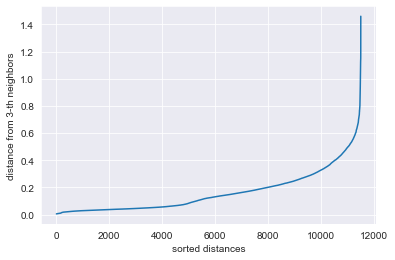

In [61]:
plt.plot(range(0, len(distances)), sorted(distances))
plt.ylabel('distance from %s-th neighbors' % 3)
plt.xlabel('sorted distances')
plt.show()

The knee of the curve is around 0.3, so values around this point will be investigated. Interstingle, our curve bens in the 0.1 neighborhood, hence also this zone is worth investigating.

In [62]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325]:
    dbscan = DBSCAN(eps=eps, min_samples=42)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+-------+----------------------+--------------------+------------+
|  eps  |      silohuette      |      DB score      | n clusters |
+-------+----------------------+--------------------+------------+
| 0.075 | 0.08159689514003385  | 1.1618571666353026 |     12     |
|  0.1  | 0.028954194770931904 | 1.1219824407733967 |     12     |
| 0.125 |  0.0890672049370497  | 1.125525294991496  |     13     |
|  0.15 |  0.1877714981341073  | 1.192304471349886  |     17     |
| 0.175 |  0.257814745089147   | 1.2342269629440121 |     19     |
|  0.2  | 0.33544815398847144  | 1.2837639287547213 |     18     |
| 0.225 |  0.3558523370818563  | 1.2800714475343584 |     13     |
|  0.25 |  0.3804363673754632  | 1.315152940281892  |     12     |
| 0.275 |  0.4191083029512266  | 1.317754788419997  |     11     |
|  0.3  | 0.41545129592994107  | 1.2521401879980585 |     13     |
| 0.325 |  0.3894192545015634  | 1.3237684823144475 |     9      |
+-------+----------------------+--------------------+---------

The zone around 0.3 seems the more promising.

In [63]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.28, 0.29, 0.3, 0.31]:
    dbscan = DBSCAN(eps=eps, min_samples=42)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+------+---------------------+--------------------+------------+
| eps  |      silohuette     |      DB score      | n clusters |
+------+---------------------+--------------------+------------+
| 0.28 | 0.38708113164324115 | 1.3078924256547084 |     12     |
| 0.29 | 0.41224775268875646 | 1.2425175105840007 |     12     |
| 0.3  | 0.41545129592994107 | 1.2521401879980585 |     13     |
| 0.31 |  0.380283411590873  | 1.2771945879577482 |     11     |
+------+---------------------+--------------------+------------+


In [64]:
dbscan = DBSCAN(eps=0.29, min_samples=42)
clusters = dbscan.fit(df_merge_scaled[numeric_attributes])

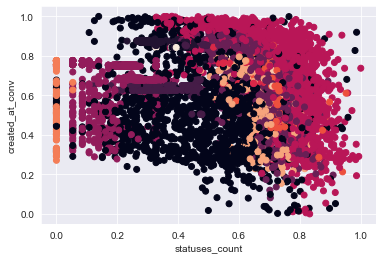

In [75]:
plt.ylabel('created_at_conv')
plt.xlabel('statuses_count')
scatterplot(df_merge_scaled, 'statuses_count', 'created_at_conv', clusters.labels_)

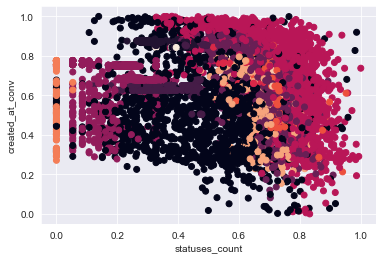

In [86]:
plt.ylabel('created_at_conv')
plt.xlabel('statuses_count')
scatterplot(df_merge_scaled, 'statuses_count', 'created_at_conv', clusters.labels_,
            filter=np.where(clusters.labels_ != -1))

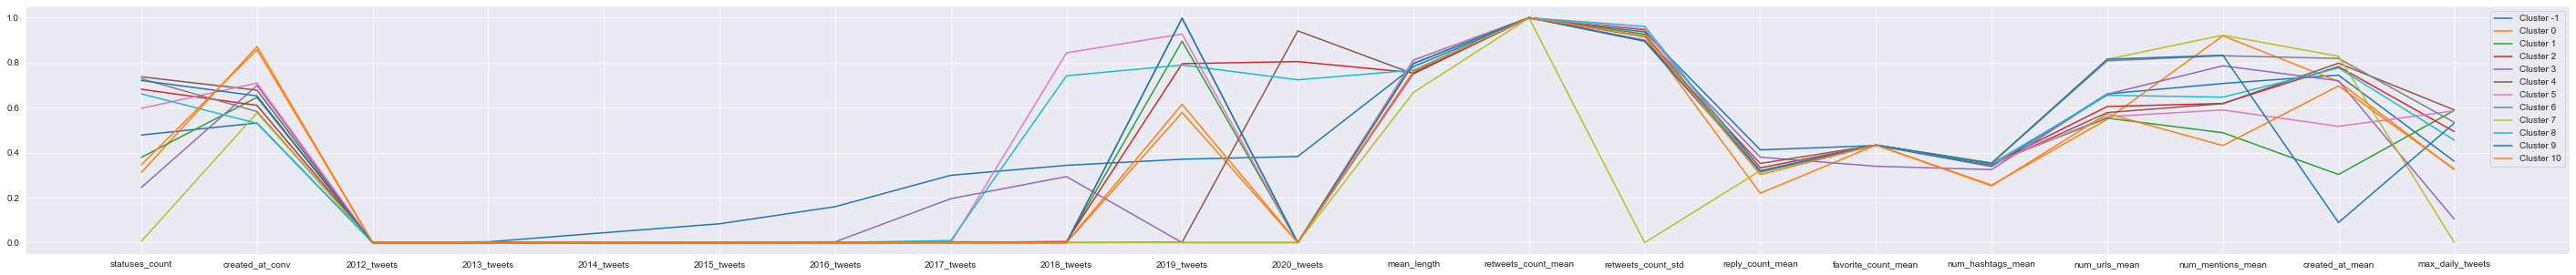

<Figure size 432x288 with 0 Axes>

In [96]:
plt.figure(figsize=(50, 5))
for label in np.unique(clusters.labels_):
    cent = df_merge_scaled[numeric_attributes][clusters.labels_ == label].mean()
    plt.plot(cent, label="Cluster %s" % label)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(numeric_attributes)), numeric_attributes)
plt.legend()
plt.show()
plt.savefig("dbscan/landascape.png")

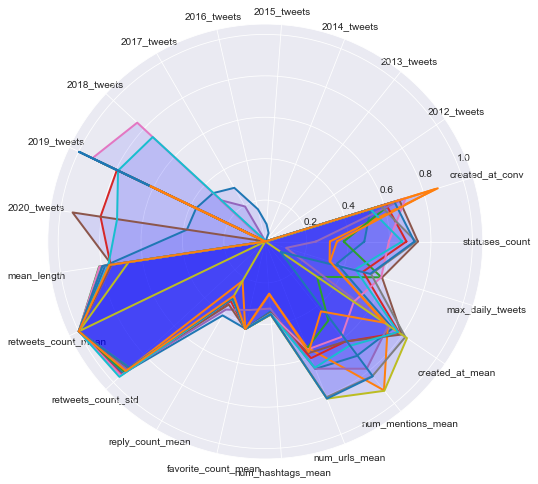

In [95]:
N = len(numeric_attributes)

plt.figure(figsize=(8, 8))
for label in np.unique(clusters.labels_):
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    values = df_merge_scaled[numeric_attributes].loc[np.where(clusters.labels_ == label)].mean().tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], df_merge_log.columns)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, 'b', alpha=0.1)

plt.savefig("dbscan/radar.png")

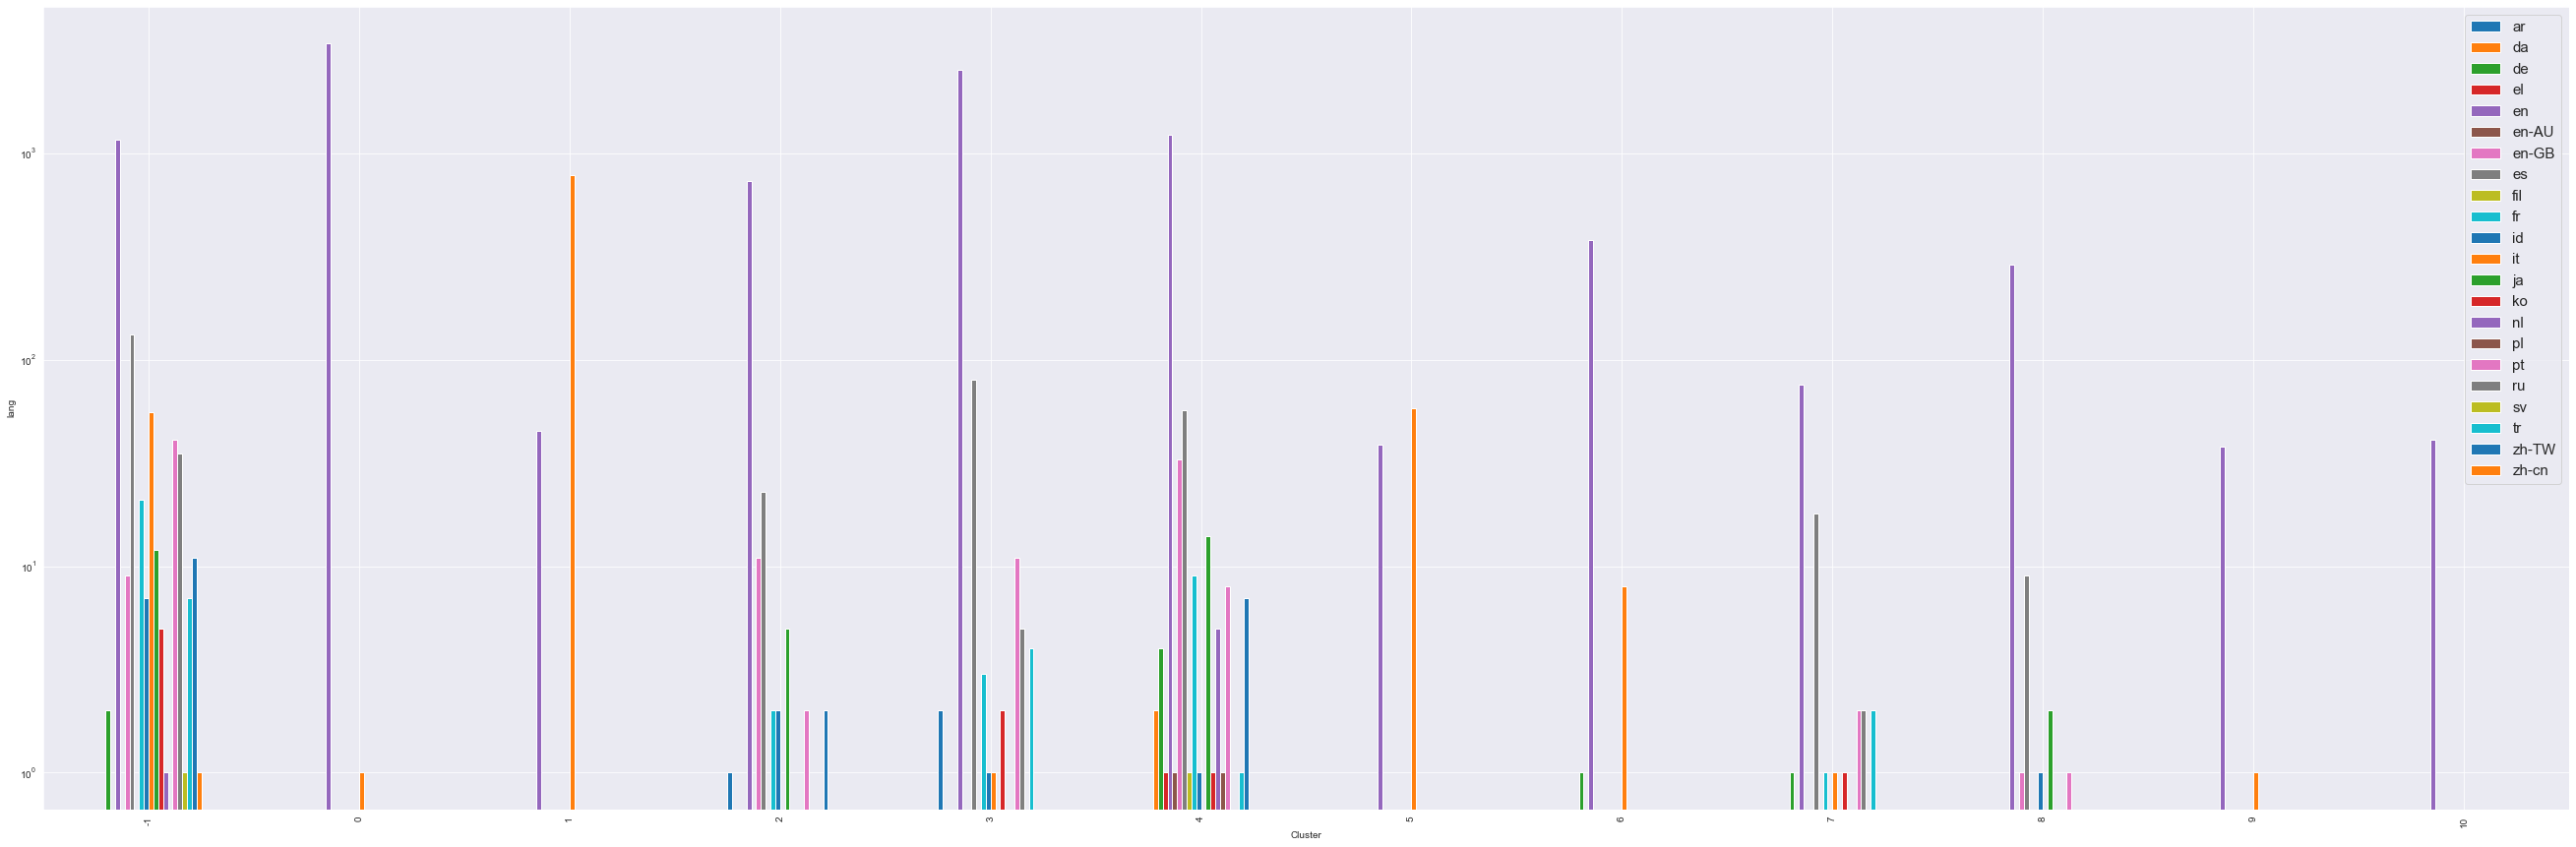

<Figure size 432x288 with 0 Axes>

In [94]:
lang_ct = pd.crosstab(clusters.labels_, df_merge['lang'])

fig, ax = plt.subplots(figsize=(46, 15))
#plt.figure(figsize=(10,25))
lang_ct.plot(kind='bar', stacked=False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('lang')
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()
plt.savefig("dbscan/lang_characterization.png")

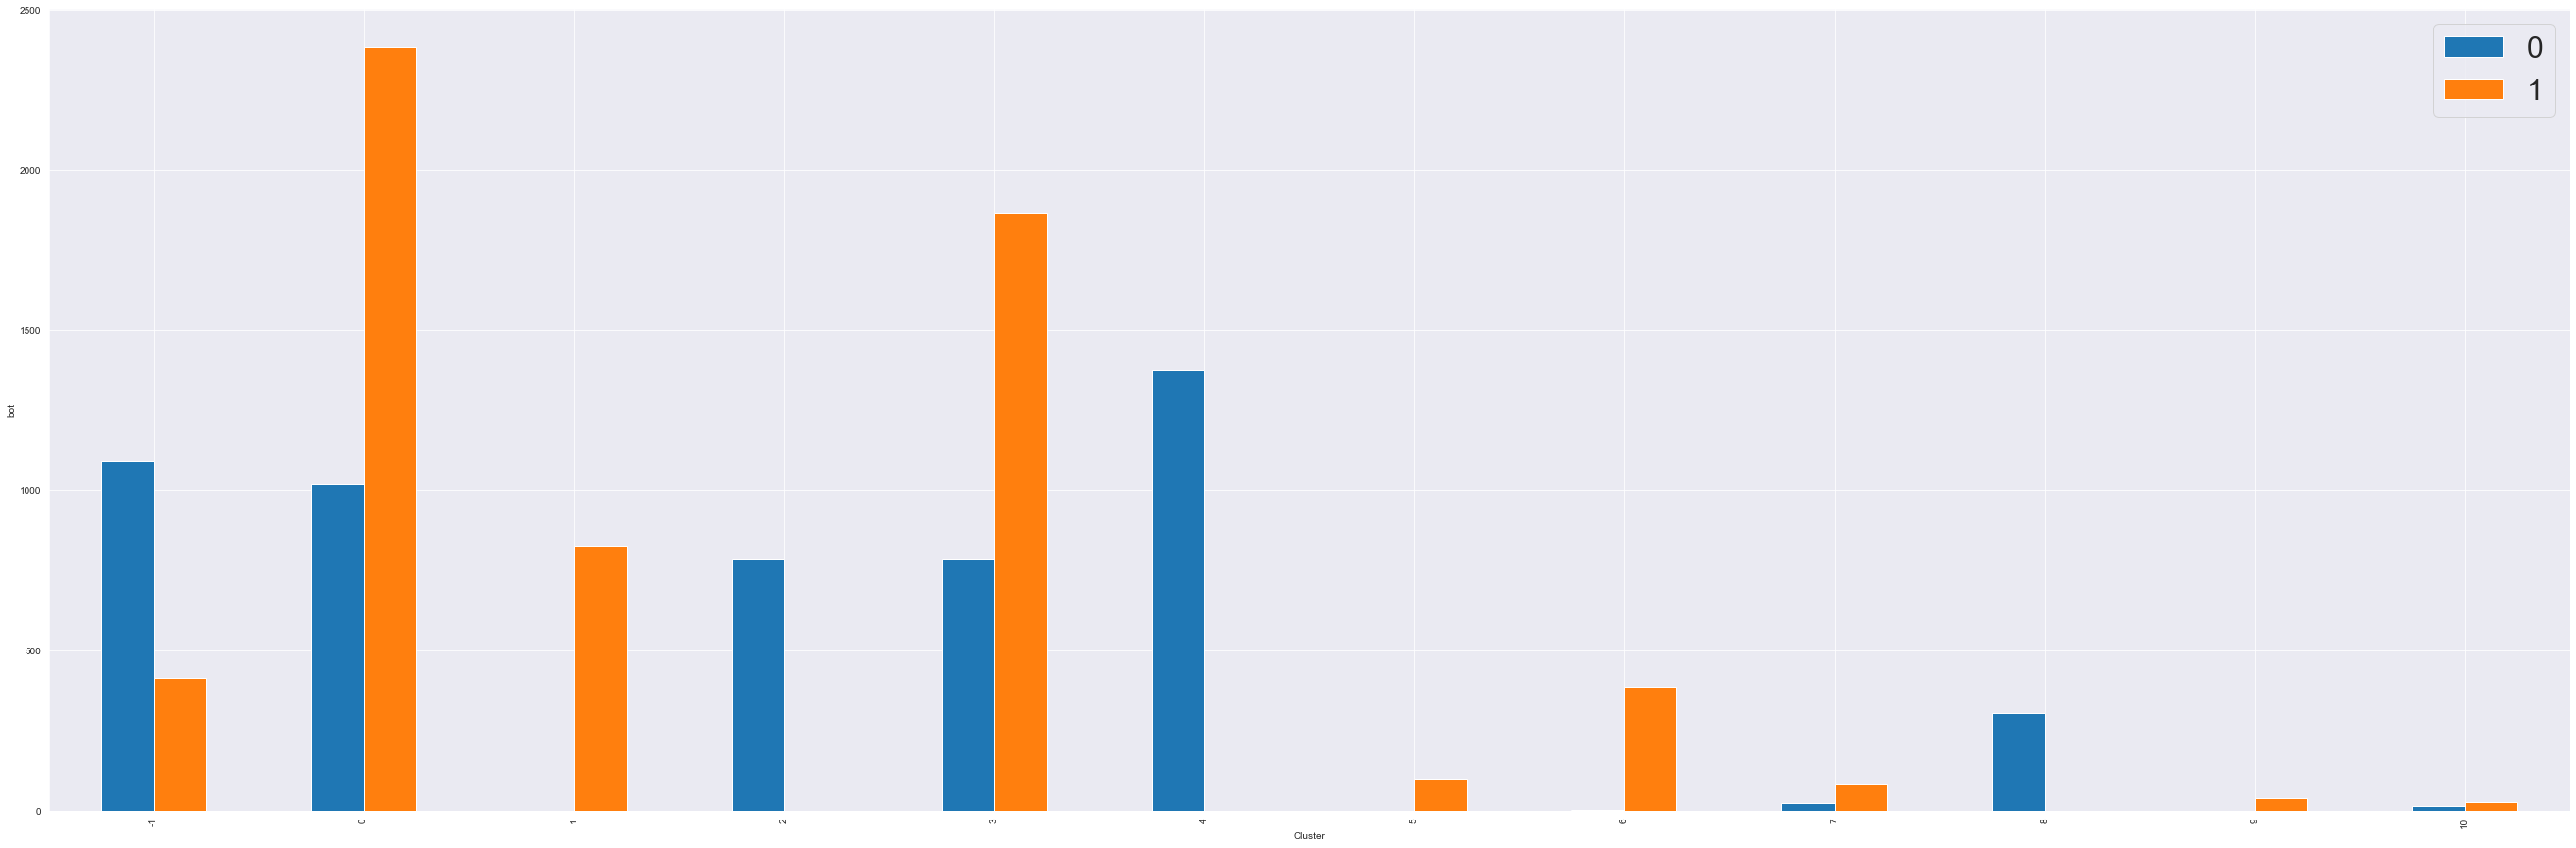

<Figure size 432x288 with 0 Axes>

In [93]:
bot_ct = pd.crosstab(clusters.labels_, df_merge['bot'])

fig, ax = plt.subplots(figsize=(46, 15))  # Sample figsize in inches
#plt.figure(figsize=(10,25))
bot_ct.plot(kind='bar', stacked=False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('bot')
plt.legend(prop={'size': 30})
plt.show()
plt.savefig("dbscan/bot_characterization.png")

In [ ]:
df_denoised = df_merge_scaled[clusters.labels_!=-1]

# KMeans

K means is run in two ways: with the complete set of users and removing the samples identified as noisy by DBscan

In [97]:
def find_optimal_k(df, max_k=40):
    sse_list = list()

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(df)
        sse_list.append(kmeans.inertia_)

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

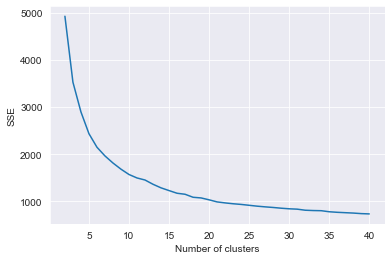

In [99]:
find_optimal_k(df_merge_scaled[numeric_attributes])

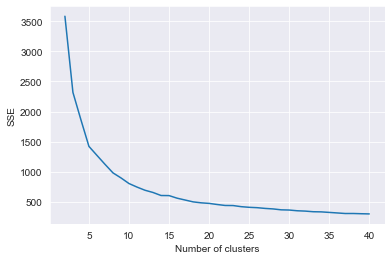

In [100]:
find_optimal_k(df_denoised[numeric_attributes])

The optimal number of clusters seems to be 7 for the log scaled data, while for the normalized data is 10.

In [119]:
def kmeans_analysis(df, k, n_init=20, max_iter=300, out_dir=None, combinations=False):
    try:
        os.mkdir(out_dir)
    except FileExistsError:
        pass

    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter)
    kmeans.fit(df[numeric_attributes])
    cent = kmeans.cluster_centers_

    get_metrics(df[numeric_attributes], kmeans.labels_)

    if combinations:
        try:
            os.mkdir(os.path.join(out_dir, 'combinations'))
        except FileExistsError:
            pass
        combs = combinations(df[numeric_attributes].columns, 2)
        os.mkdir('kmeans')
        os.mkdir('kmeans/log_denoised')
        for comb in combs:
            plt.ylabel(comb[1])
            plt.xlabel(comb[0])
            print(*comb)
            scatterplot(df, *comb, kmeans.labels_, centroids=cent,
                        filename=os.path.join(out_dir, 'combinations', f"scatterplot_{comb[1]}_{comb[0]}.png"))
    else:
        scatterplot(df, 'created_at_conv', 'statuses_count', kmeans.labels_,
                    centroids=cent, filename=os.path.join(out_dir, "clusters"))

    plt.figure(figsize=(50, 5))
    for i in range(0, len(cent)):
        plt.plot(cent[i], label="Cluster %s" % i)
    plt.tick_params(axis='both', which='major')
    plt.xticks(range(0, len(df[numeric_attributes].columns)), df[numeric_attributes].columns)
    plt.legend()
    #plt.show()
    if out_dir is not None:
        plt.savefig(os.path.join(out_dir, f"landscape.png"))

    plt.figure(figsize=(8, 8))
    N = len(df[numeric_attributes].columns)
    for i in range(0, len(cent)):
        angles = [n / float(N) * 2 * math.pi for n in range(N)]
        values = cent[i].tolist()
        values += values[:1]
        angles += angles[:1]

        ax = plt.subplot(polar=True)
        plt.xticks(angles[:-1], df[numeric_attributes].columns)
        ax.plot(angles, values, linewidth=2)
        ax.fill(angles, values, 'b', alpha=0.1)
    if out_dir is not None:
        plt.savefig(os.path.join(out_dir, f"radar_plot.png"))

    lang_ct = pd.crosstab(kmeans.labels_, df['lang'])
    fig, ax = plt.subplots(figsize=(46, 15))
    #plt.figure(figsize=(10,25))
    lang_ct.plot(kind='bar', stacked=False, ax=ax)
    plt.xlabel('Cluster')
    plt.ylabel('lang')
    plt.yscale('log')
    plt.legend(prop={'size': 15})
    #plt.show()
    if out_dir is not None:
        plt.savefig(os.path.join(out_dir, f"lang_characterization.png"))

    bot_ct = pd.crosstab(kmeans.labels_, df['bot'])
    fig, ax = plt.subplots(figsize=(46, 15))  # Sample figsize in inches
    #plt.figure(figsize=(10,25))
    bot_ct.plot(kind='bar', stacked=False, ax=ax)
    plt.xlabel('Cluster')
    plt.ylabel('bot')
    plt.legend(prop={'size': 30})
    #plt.show()
    if out_dir is not None:
        plt.savefig(os.path.join(out_dir, f"bot_characterization.png"))

Silouhette score: 0.46795875488884614
Davies Bouldin score: 1.1505184121627567


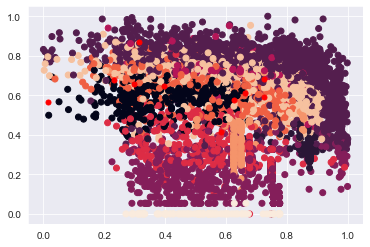

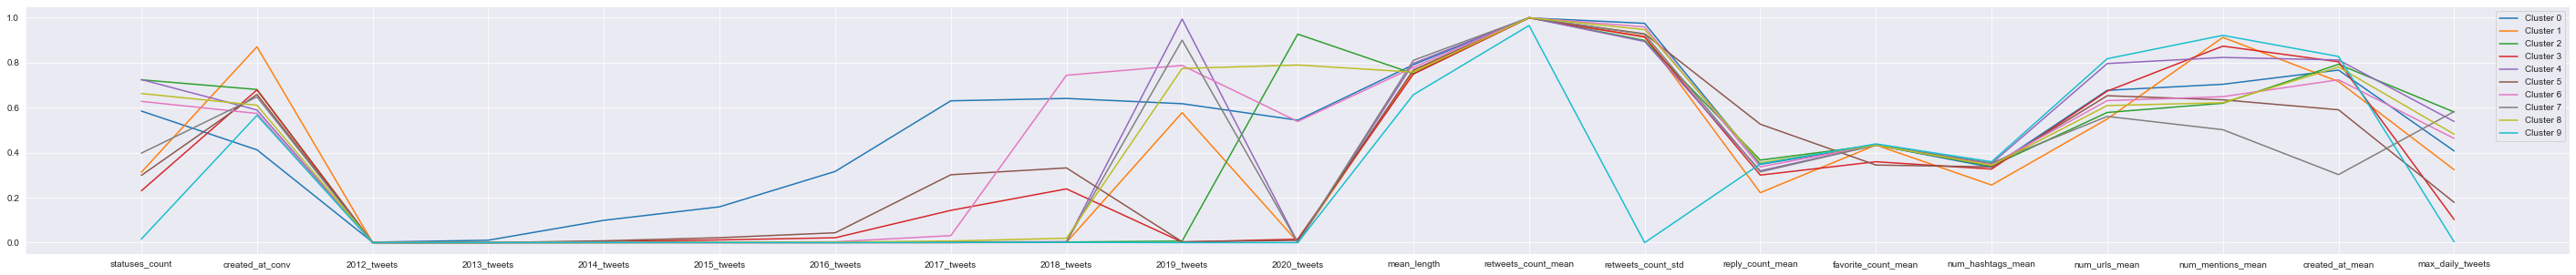

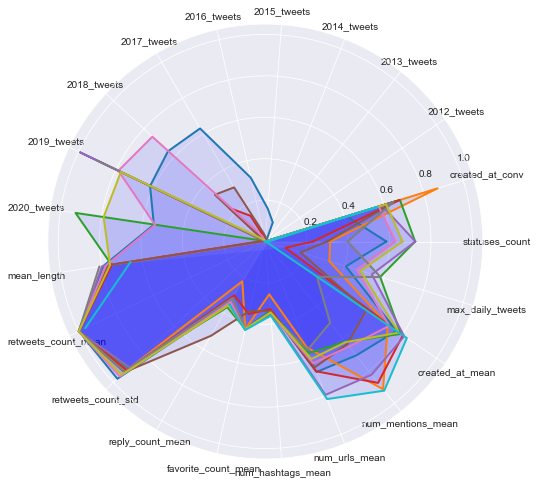

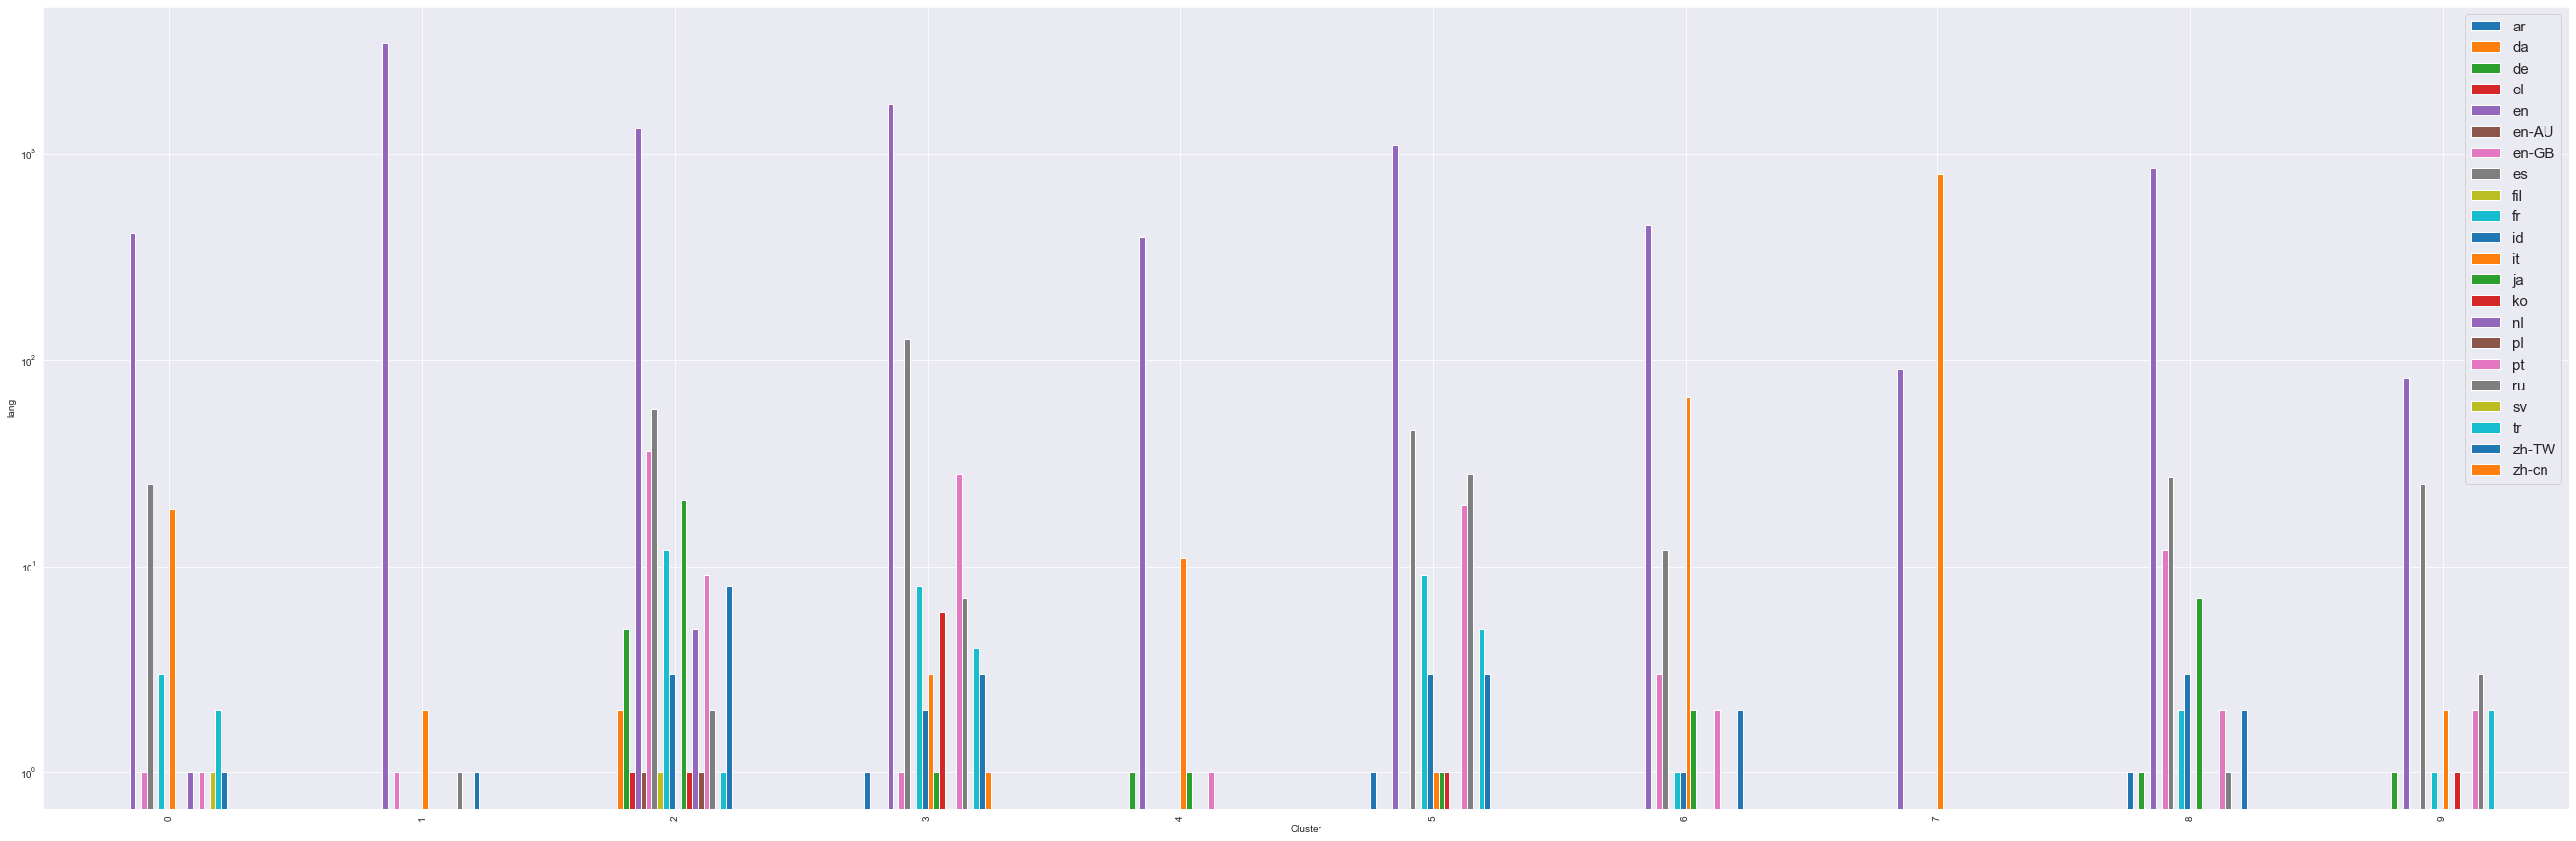

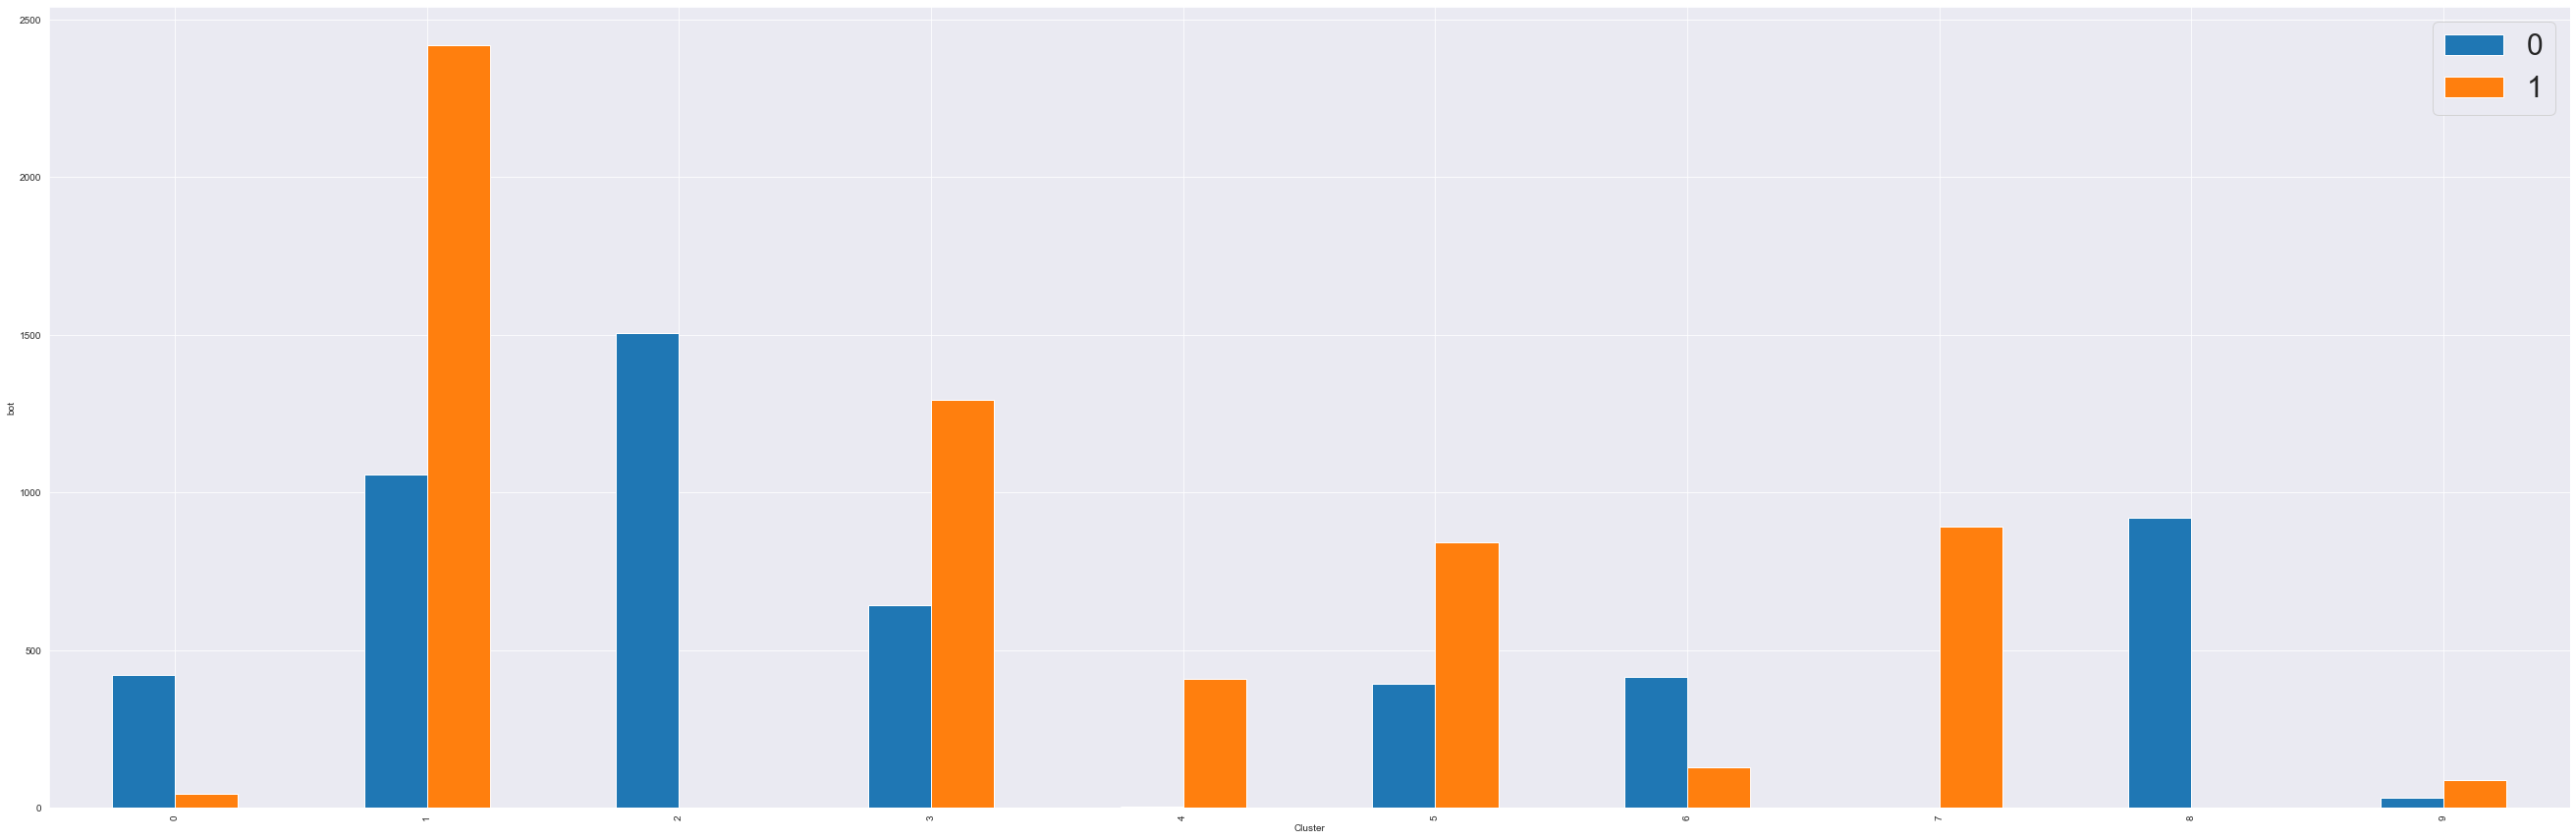

In [120]:
kmeans_analysis(df_merge_scaled, k=10, out_dir='kmeans/scaled_k10')

Silouhette score: 0.5122081730297648
Davies Bouldin score: 1.0242155378699824


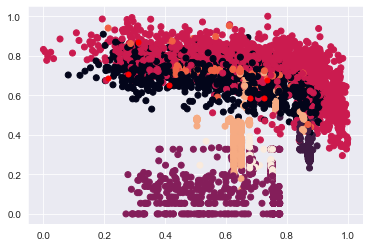

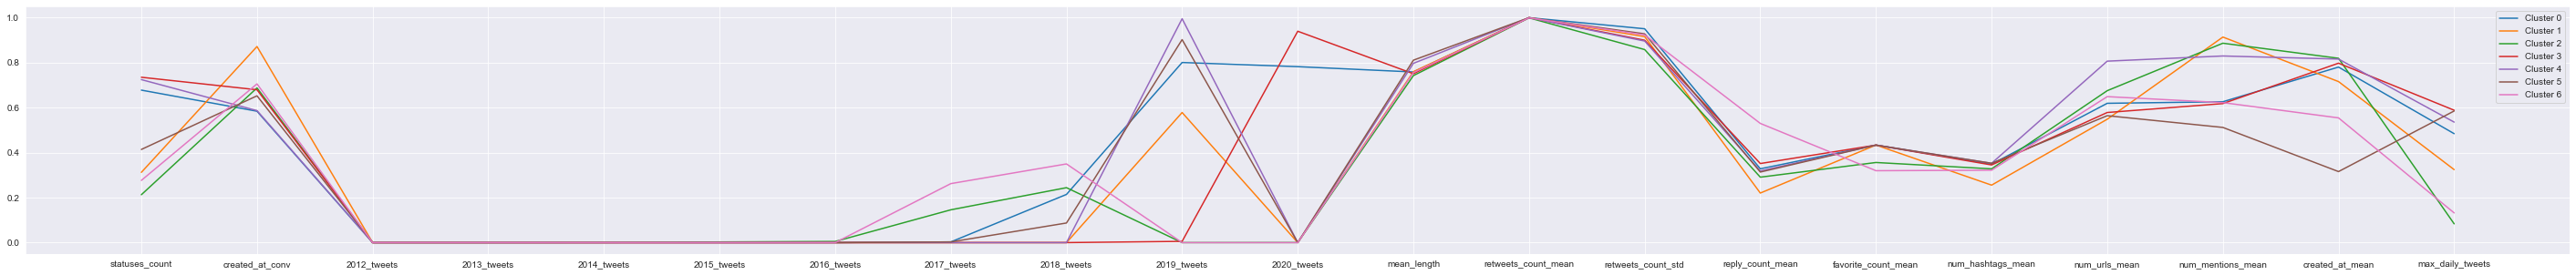

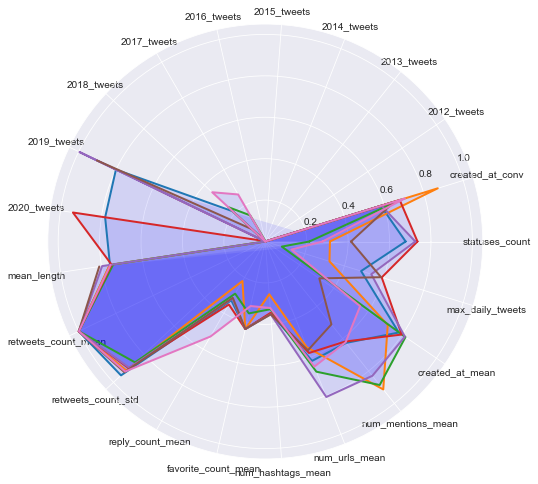

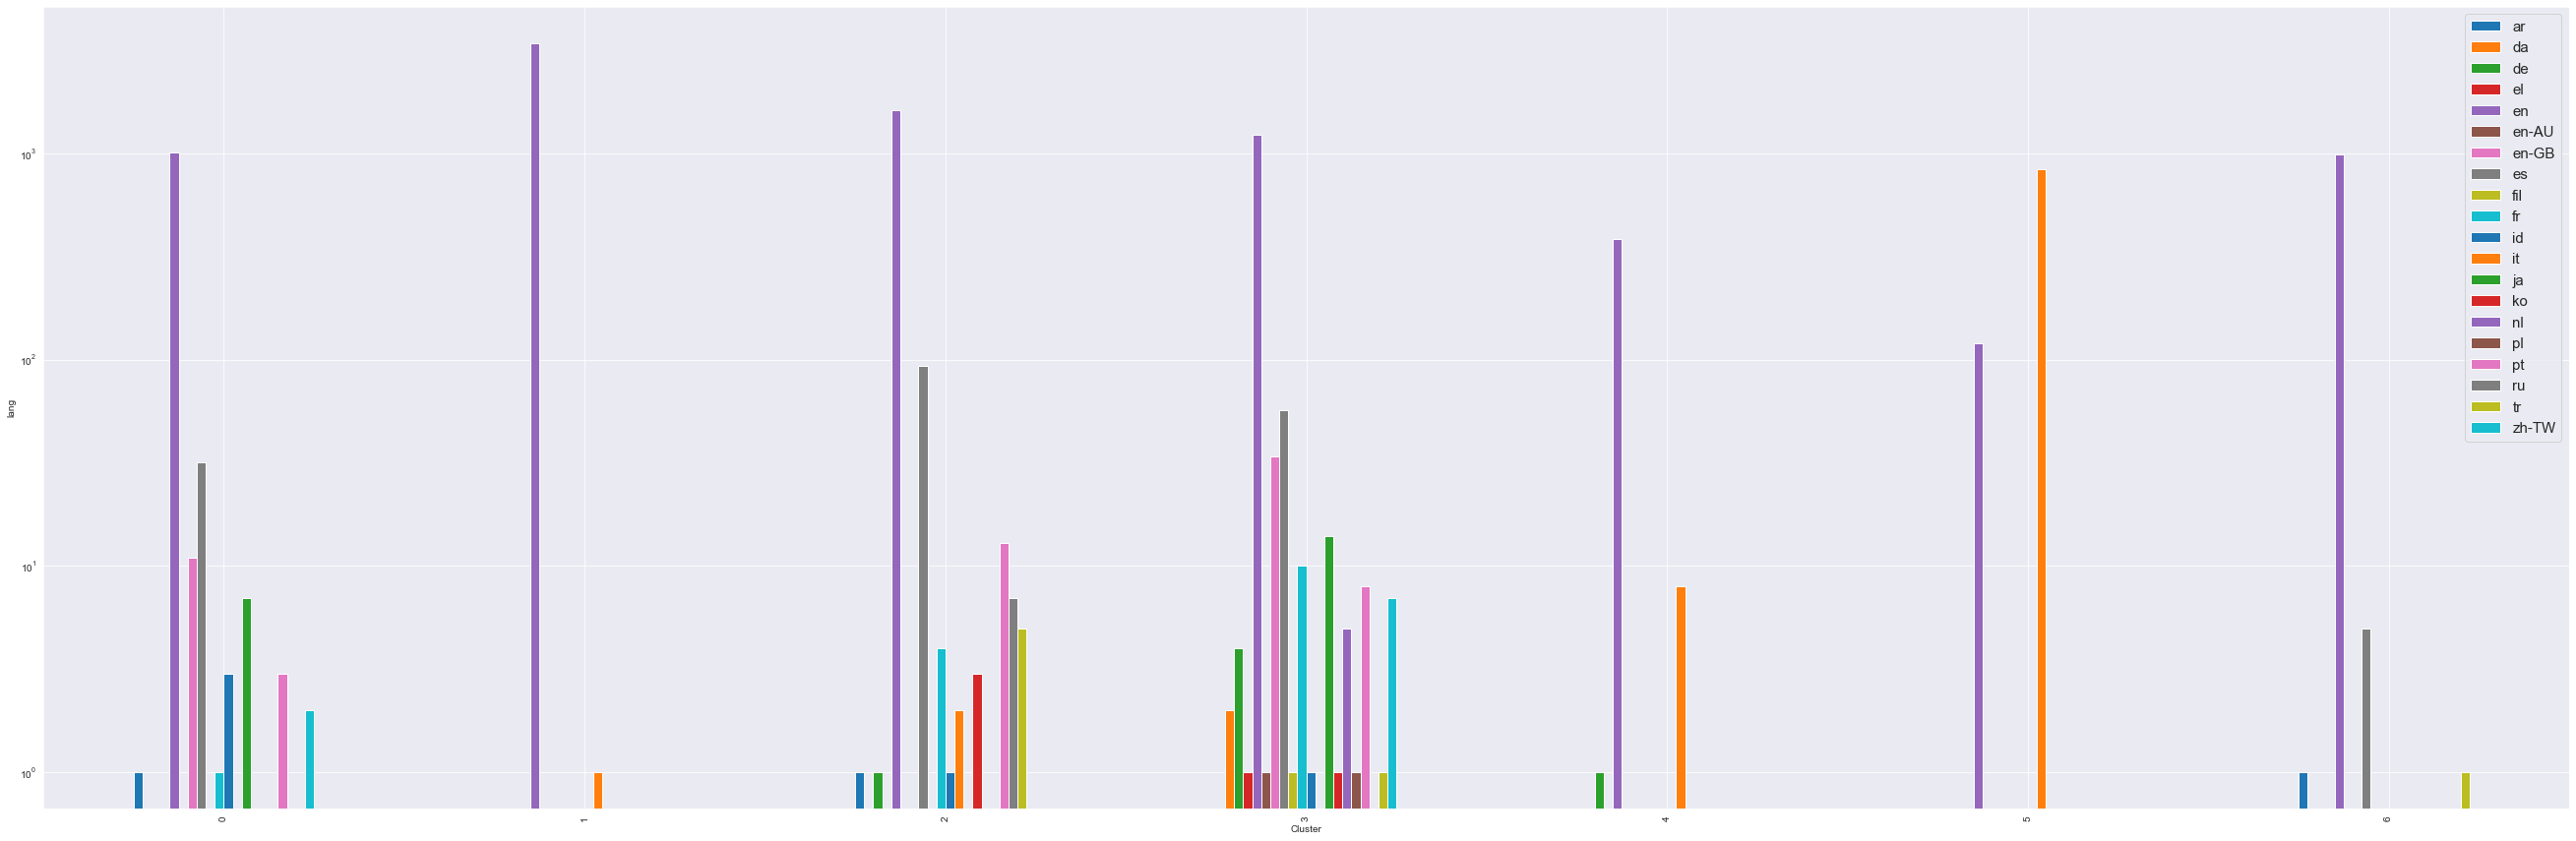

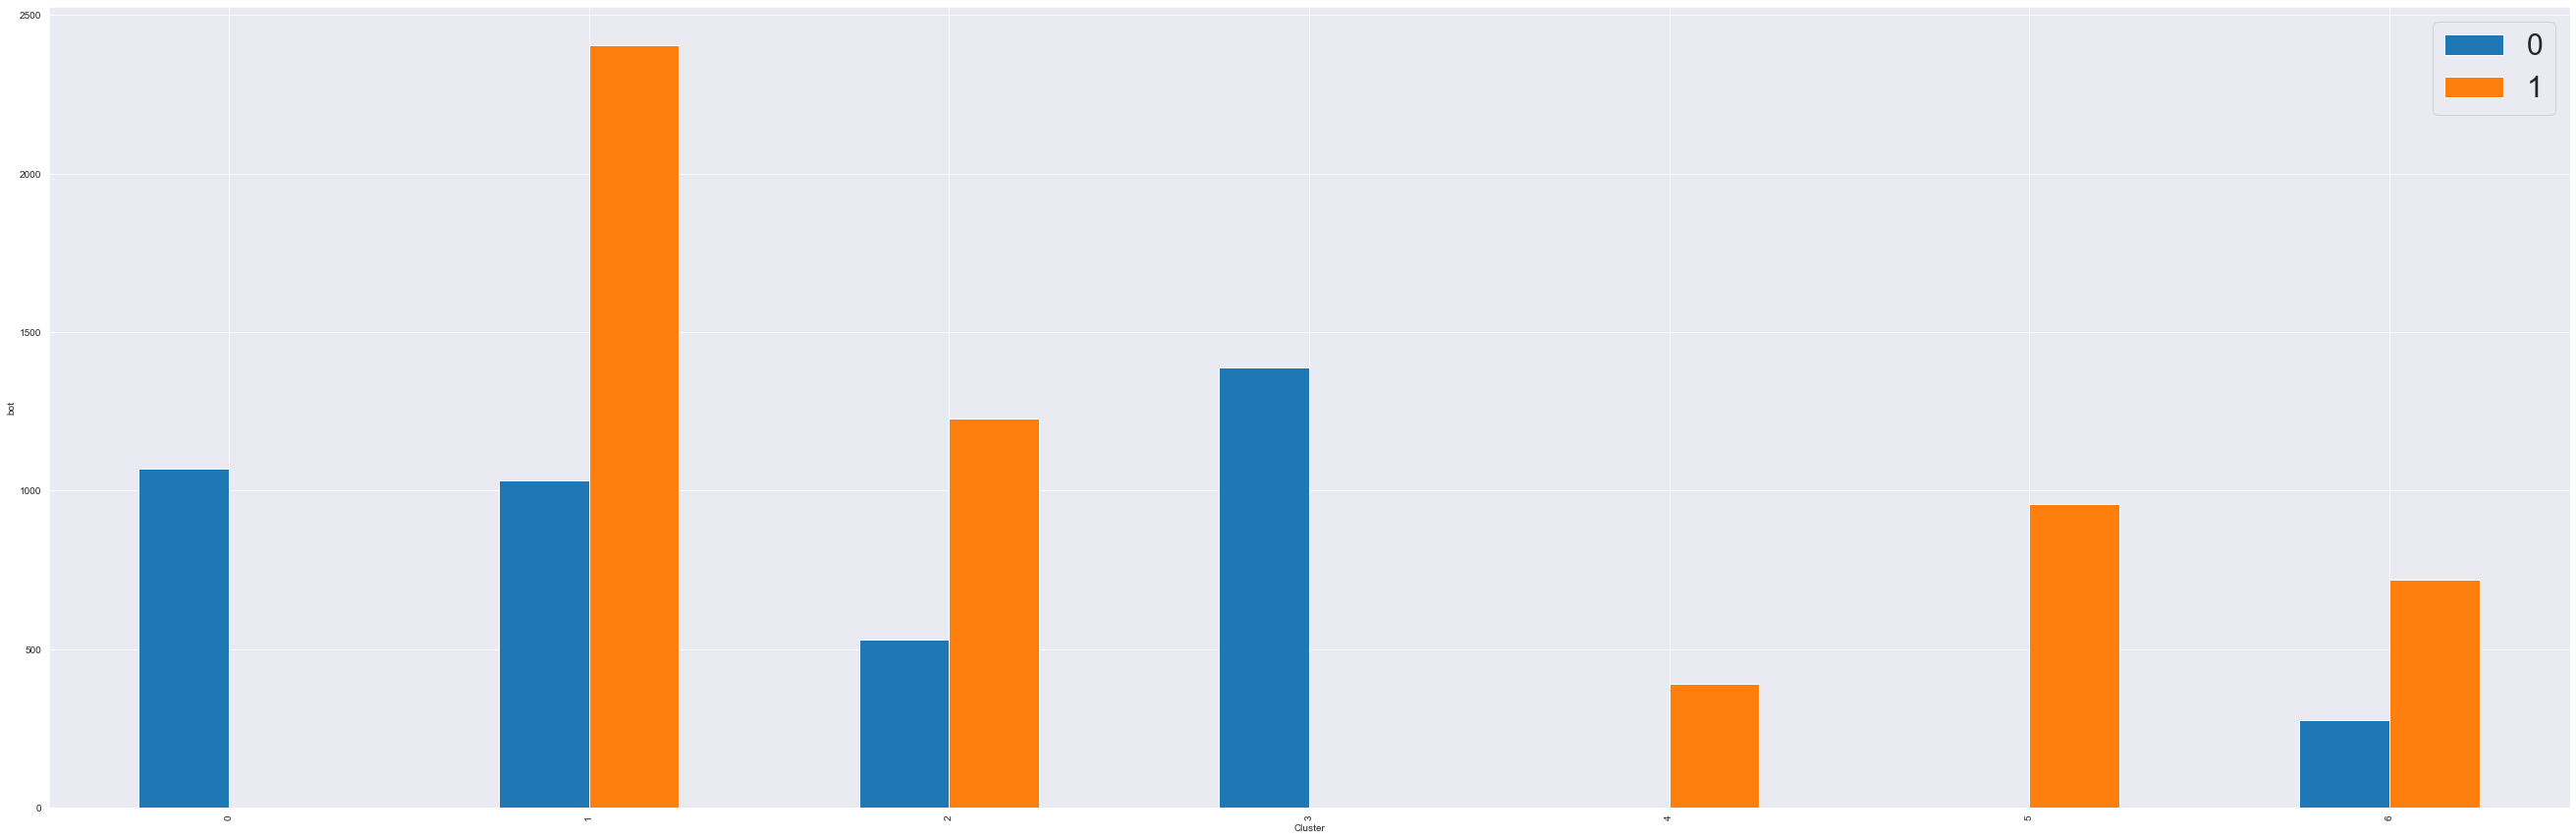

In [147]:
kmeans_analysis(df_denoised, k=7, out_dir='kmeans/denoised_k7')

Silouhette score: 0.5265355737877931
Davies Bouldin score: 0.9629460508378525


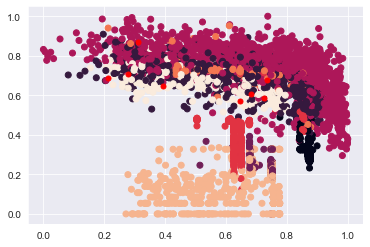

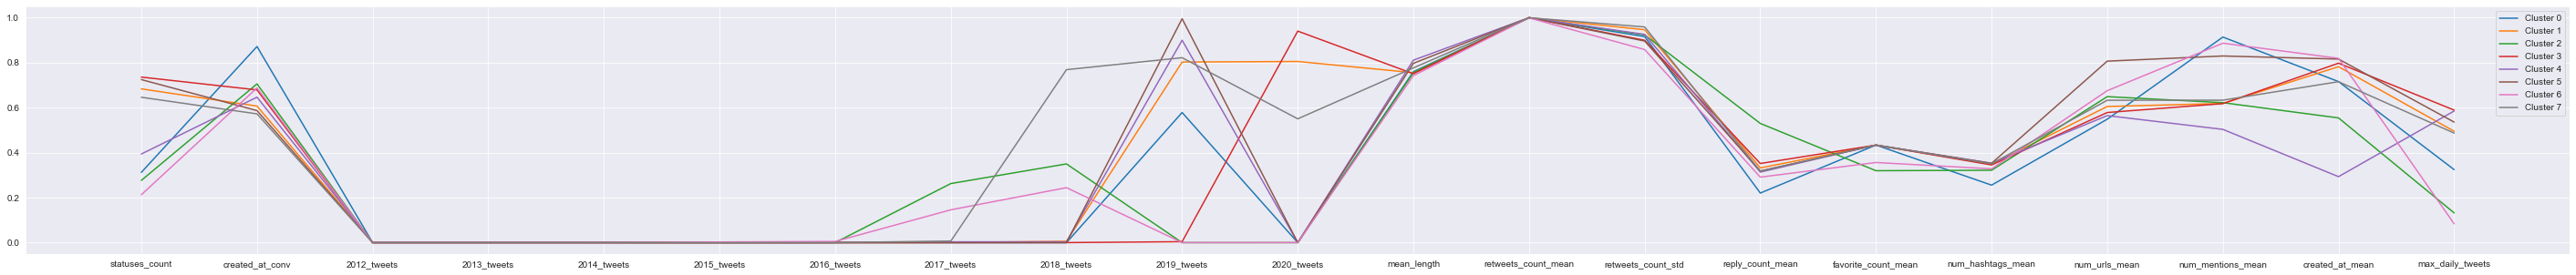

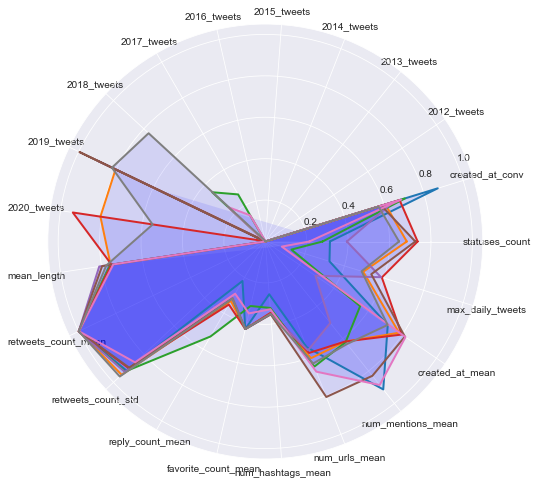

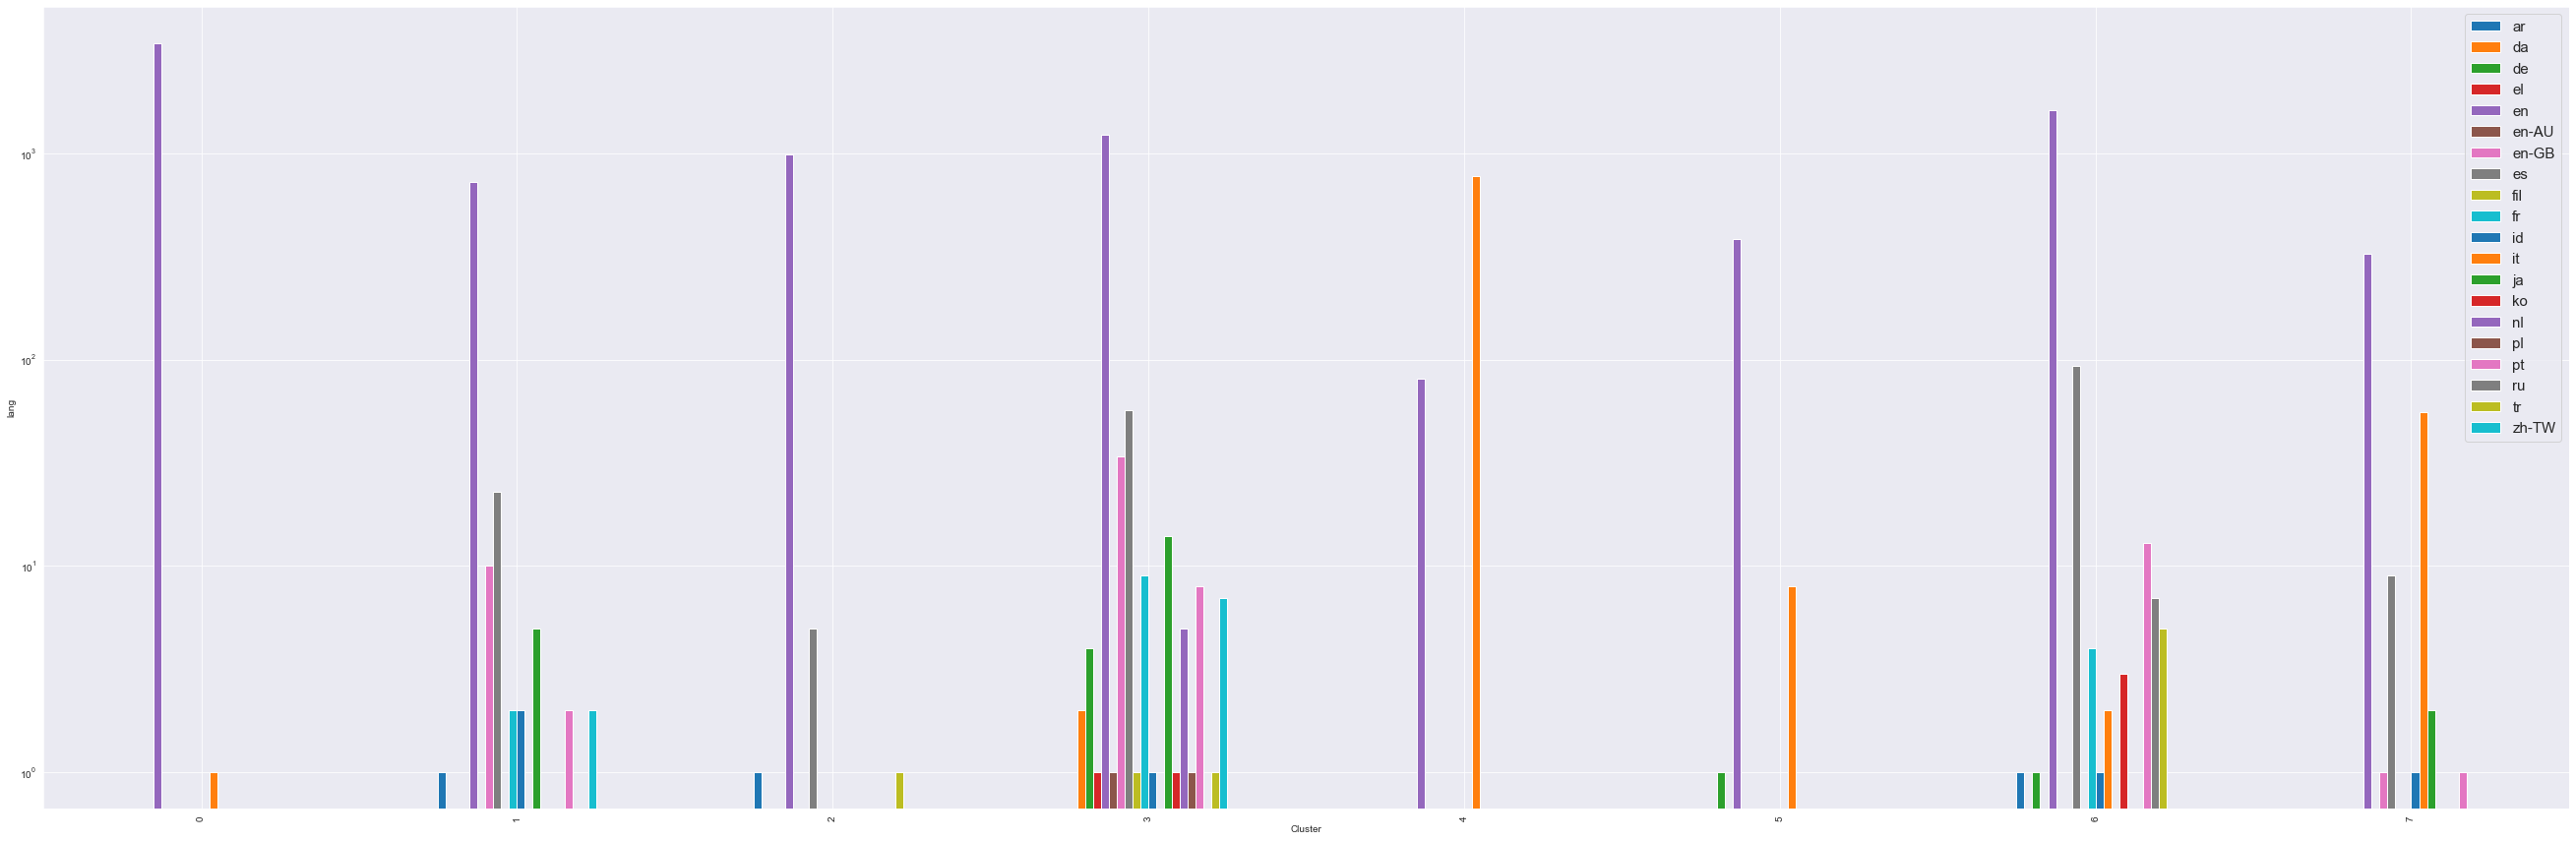

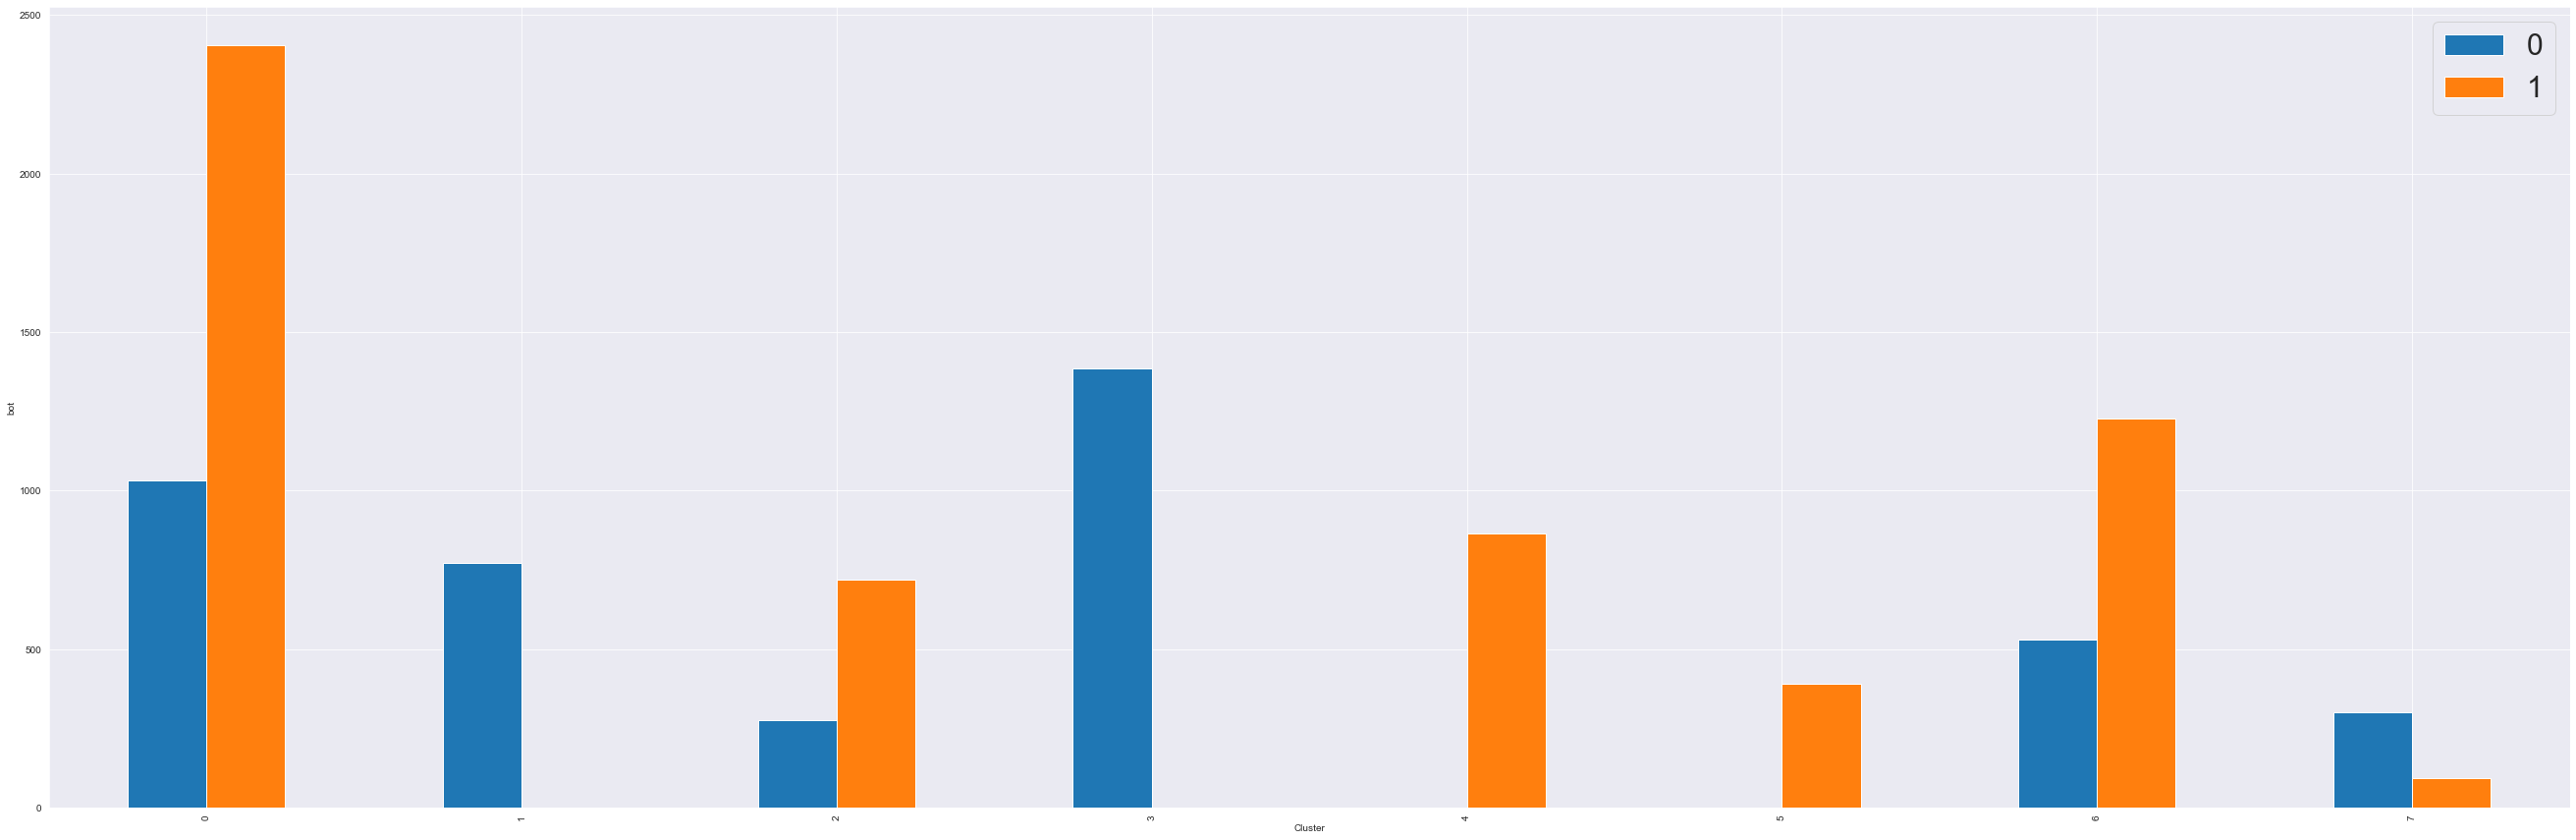

In [143]:
kmeans_analysis(df_denoised, k=8, out_dir='kmeans/denoised_k8')

Silouhette score: 0.5374736259354937
Davies Bouldin score: 0.8971197680196631


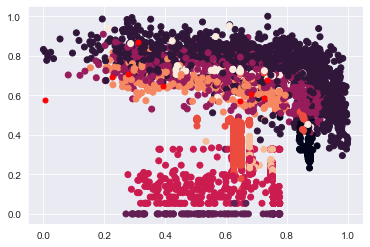

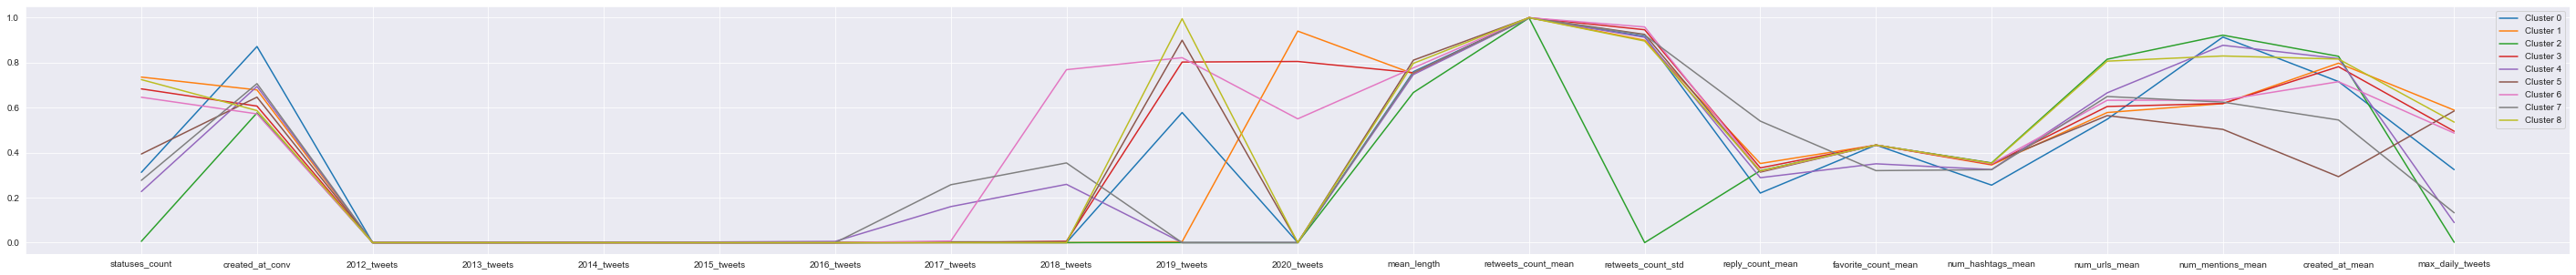

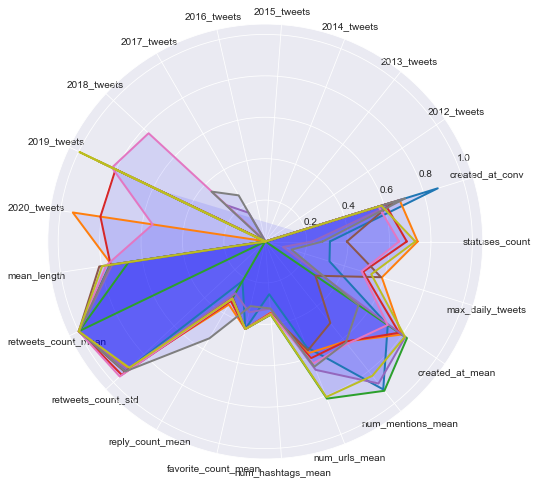

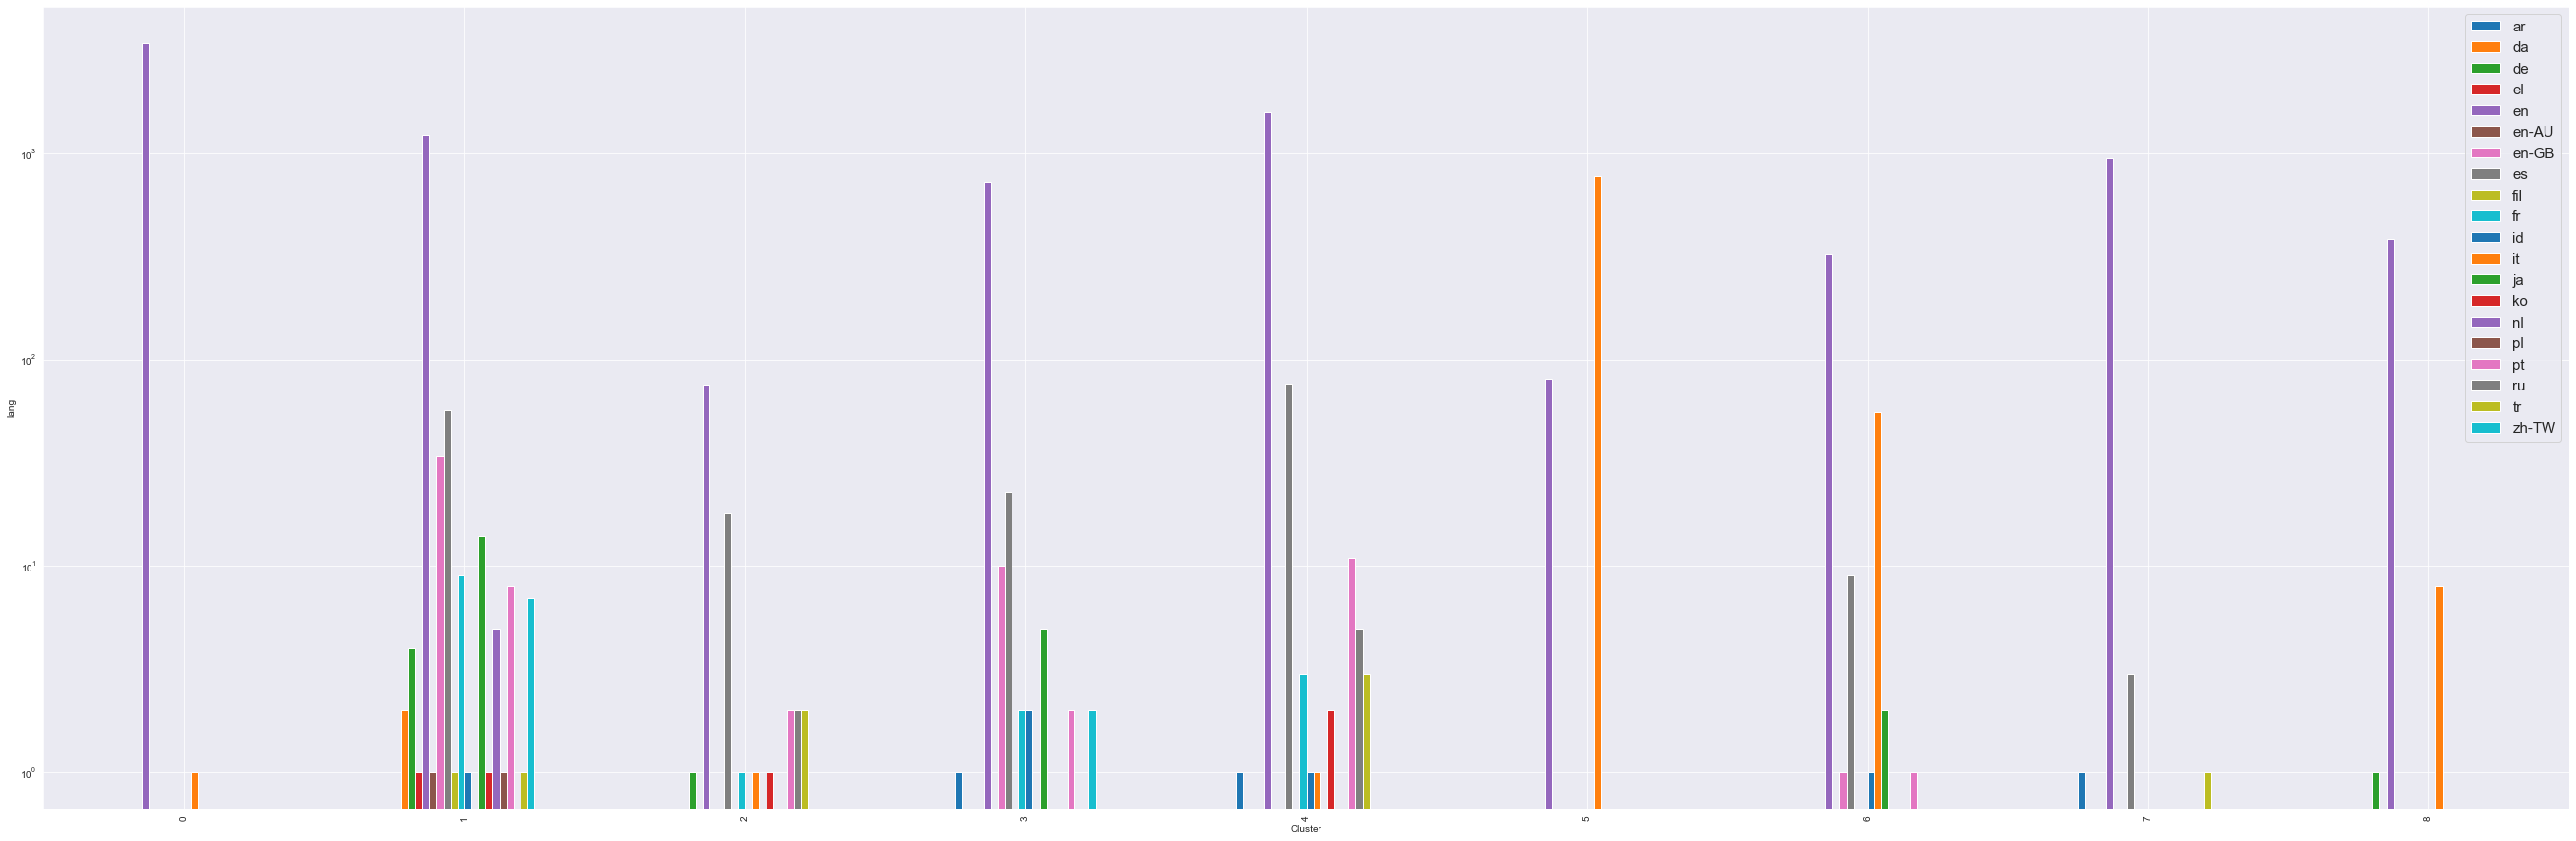

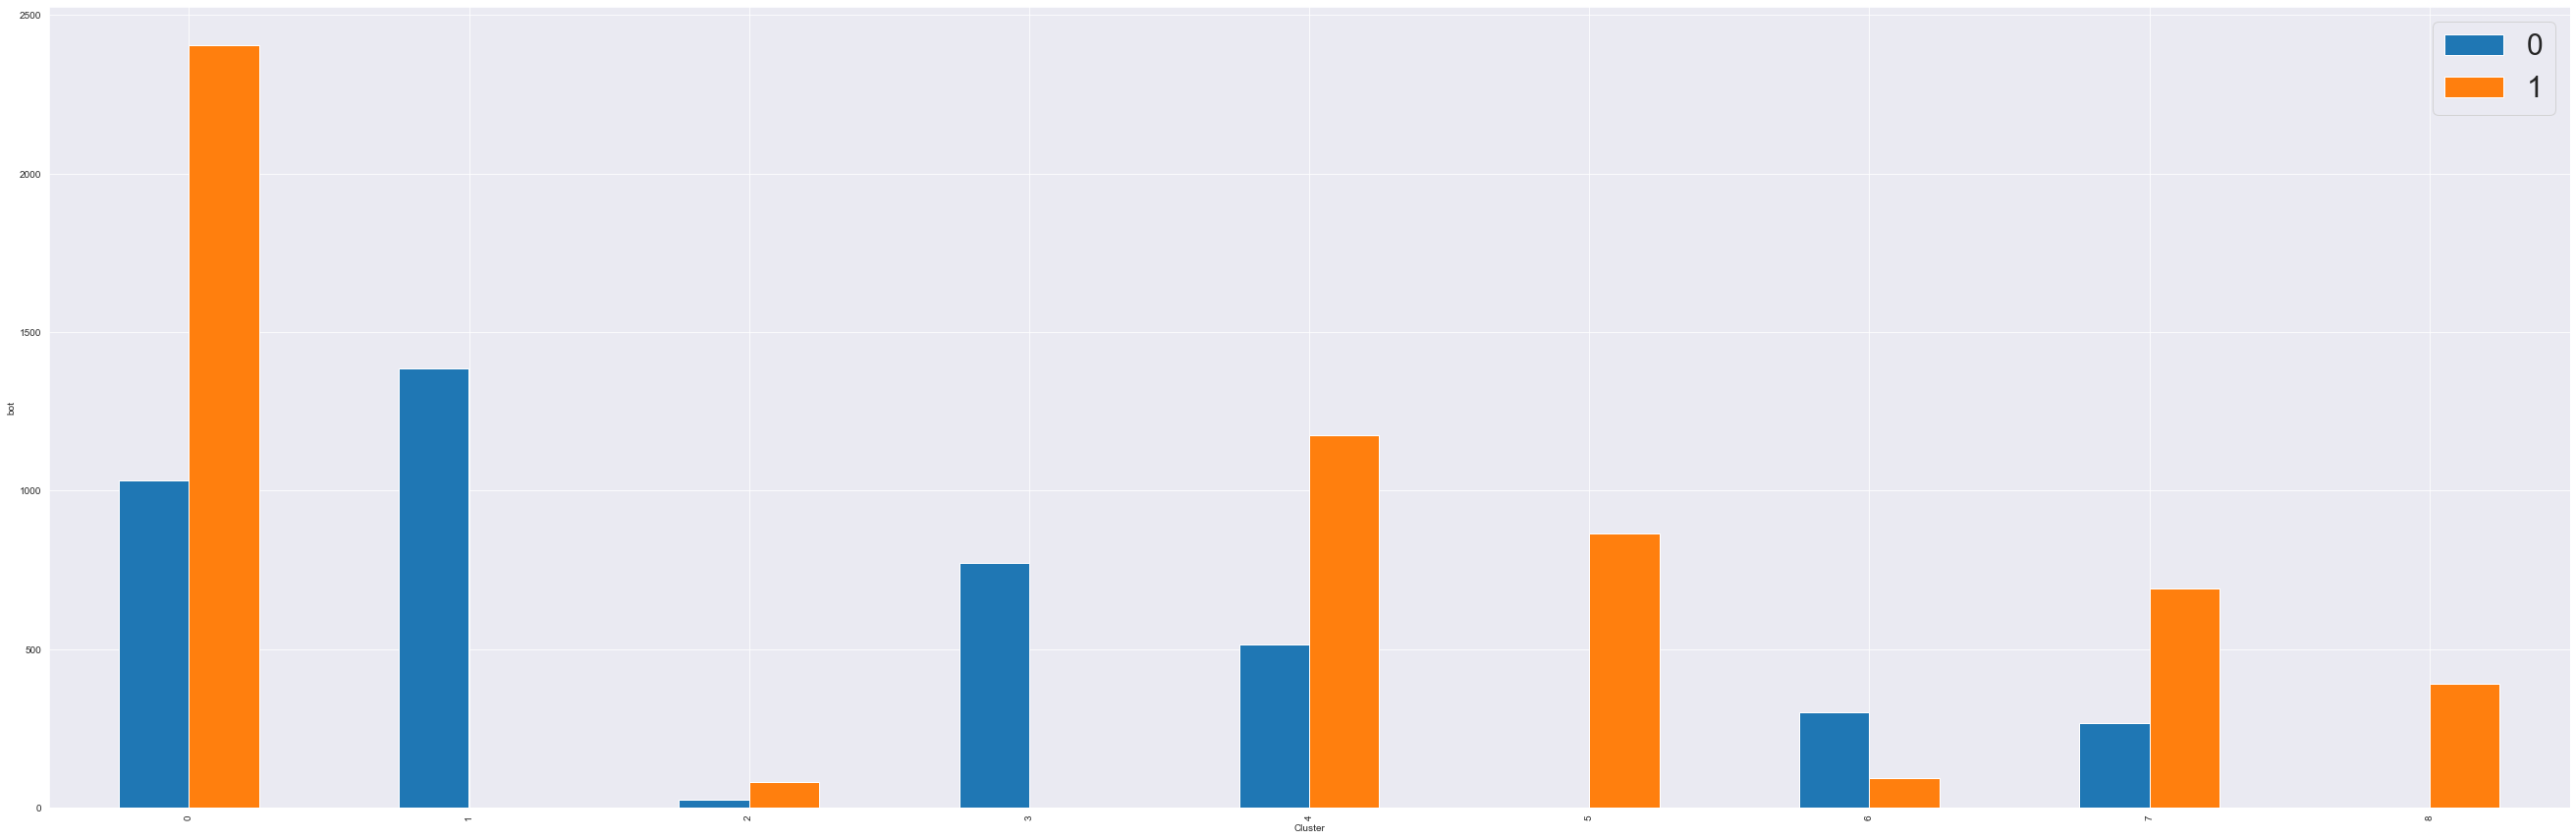

In [144]:
kmeans_analysis(df_denoised, k=9, out_dir='kmeans/denoised_k9')

Silouhette score: 0.5343835484616772
Davies Bouldin score: 0.884450862103523


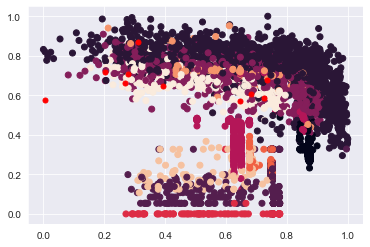

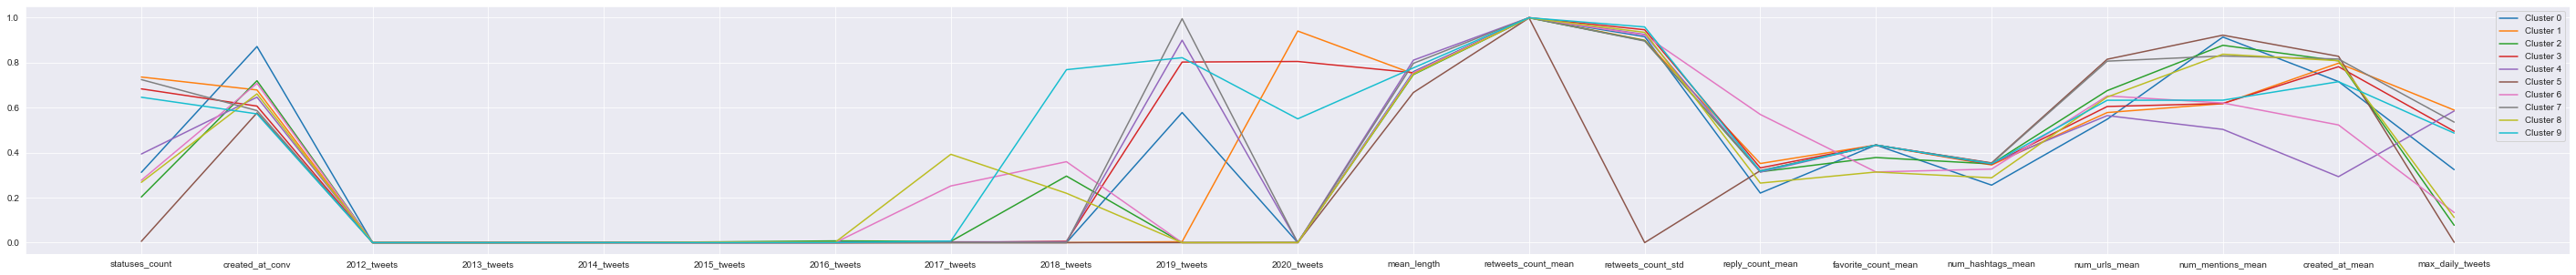

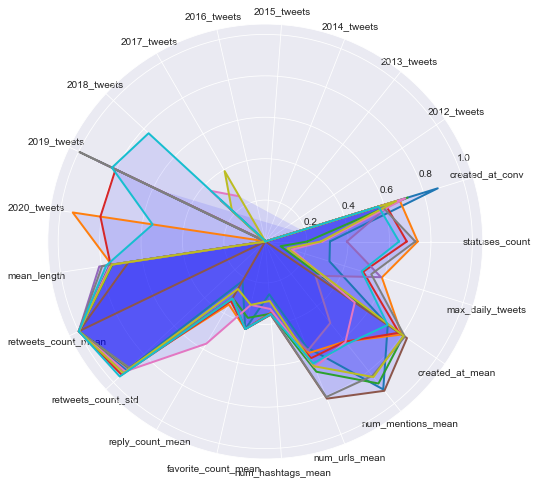

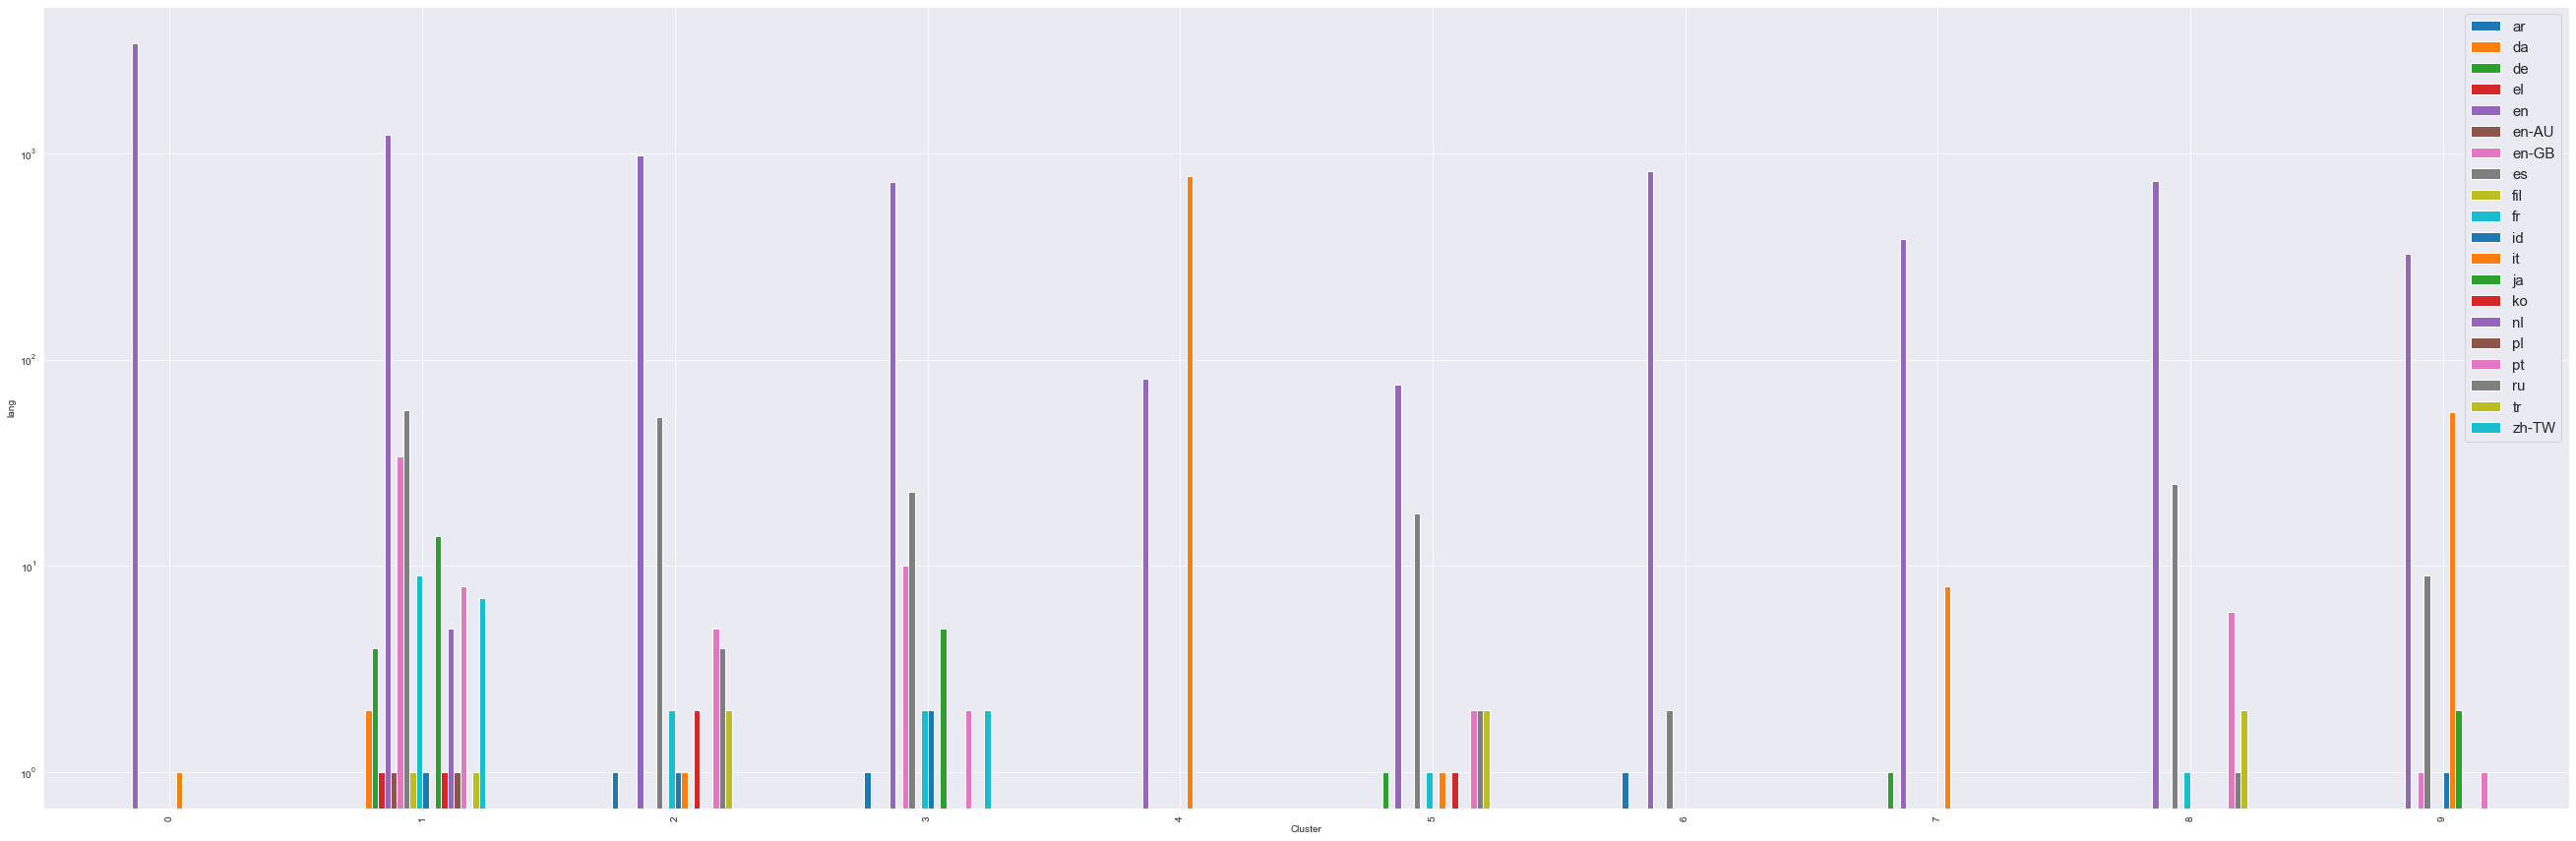

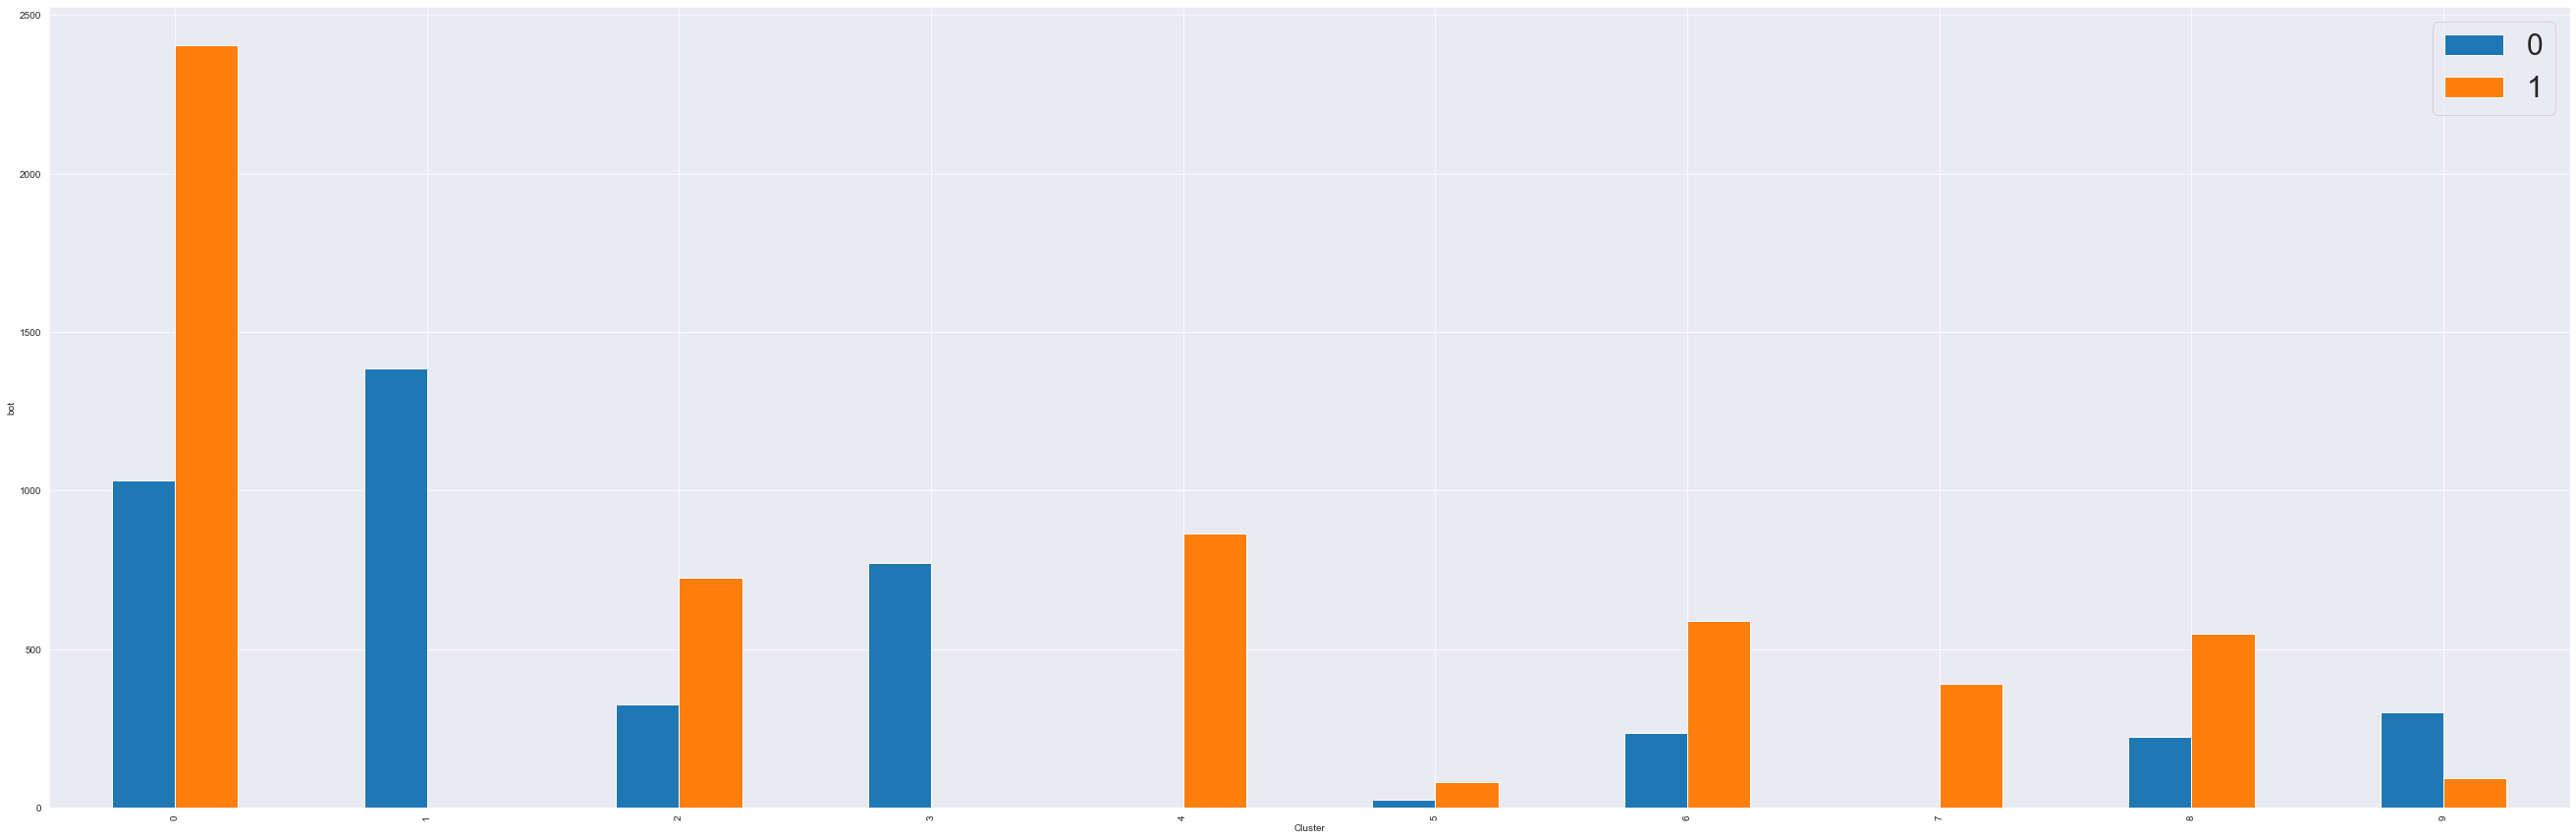

In [146]:
kmeans_analysis(df_denoised, k=10, out_dir='kmeans/denoised_k10')

# Hierarchical clustering

In [127]:
metric = 'euclidean'
distances = pdist(df_merge_scaled[numeric_attributes], metric=metric)

In [128]:
dlinkage = linkage(distances, metric=metric, method='complete')

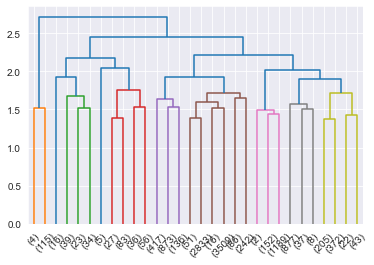

In [129]:
res = dendrogram(dlinkage, truncate_mode='lastp')

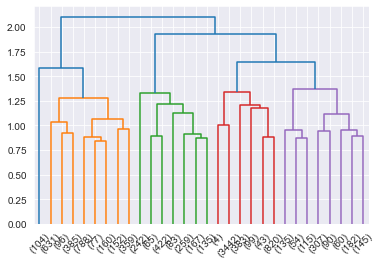

In [134]:
metric = 'euclidean'
distances = pdist(df_denoised[numeric_attributes], metric=metric)
dlinkage = linkage(distances, metric=metric, method='complete')
res = dendrogram(dlinkage, truncate_mode='lastp')

In [ ]:
# non piace alla Naretto perché bisogna scegliere # di clusters
clusters = AgglomerativeClustering(affinity='euclidean', n_clusters=6, linkage='ward')
clusters.fit(df_merge_scaled[numeric_attributes])
# or -> clusters.fit_predict(df_merge_scaled)

In [148]:
get_metrics(df_merge_scaled[numeric_attributes],clusters.labels_)

Silouhette score: 0.42320501329769156
Davies Bouldin score: 1.0700477015855128


C:\Users\al\AppData\Local\Temp\ipykernel_12736\3284260963.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cent = df_merge_scaled.loc[np.where(clusters.labels_ == label)].mean()
C:\Users\al\AppData\Local\Temp\ipykernel_12736\3284260963.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cent = df_merge_scaled.loc[np.where(clusters.labels_ == label)].mean()
C:\Users\al\AppData\Local\Temp\ipykernel_12736\3284260963.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cent = df_merge_sc

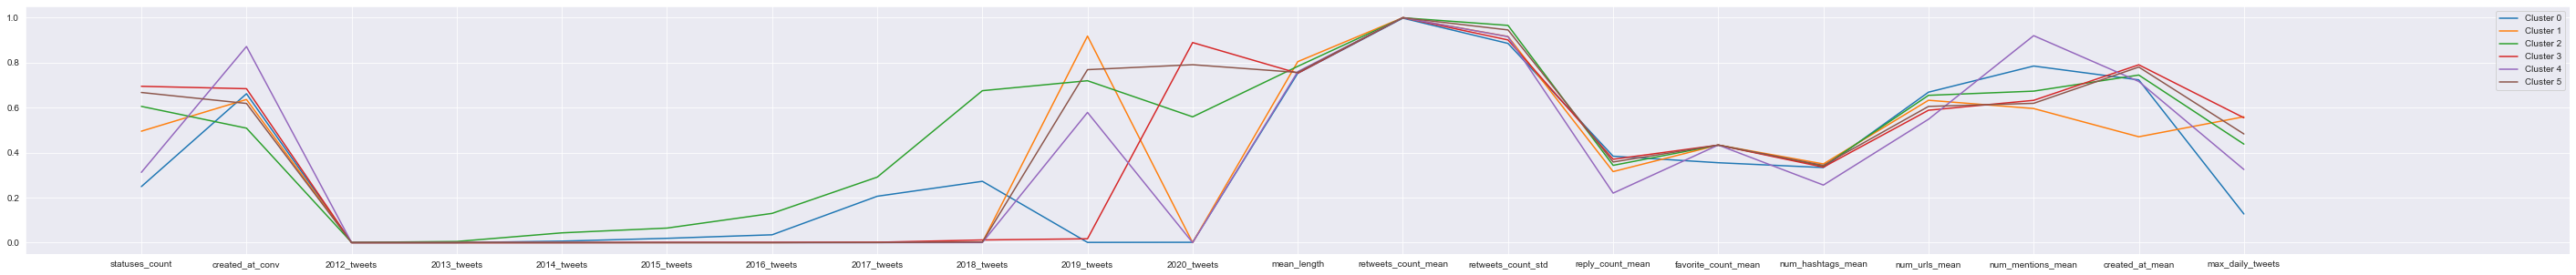

In [137]:
plt.figure(figsize=(50, 5))
for label in np.unique(clusters.labels_):
    cent = df_merge_scaled.loc[np.where(clusters.labels_ == label)].mean()
    plt.plot(cent, label="Cluster %s" % label)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(numeric_attributes)), numeric_attributes)
plt.legend()
plt.show()

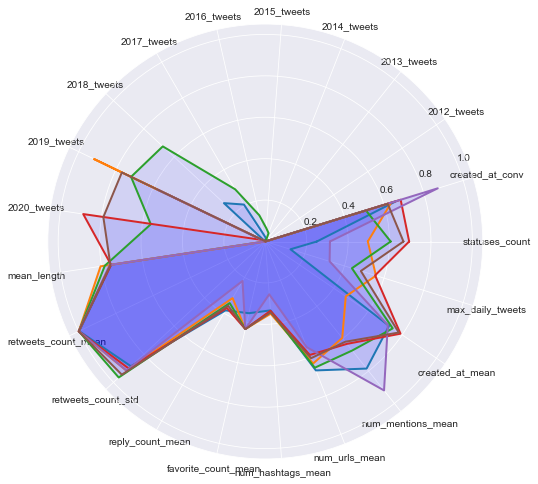

In [140]:
N = len(numeric_attributes)

plt.figure(figsize=(8, 8))
for label in np.unique(clusters.labels_):
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    values = df_merge_scaled[numeric_attributes].loc[np.where(clusters.labels_ == label)].mean().tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], numeric_attributes)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, 'b', alpha=0.1)

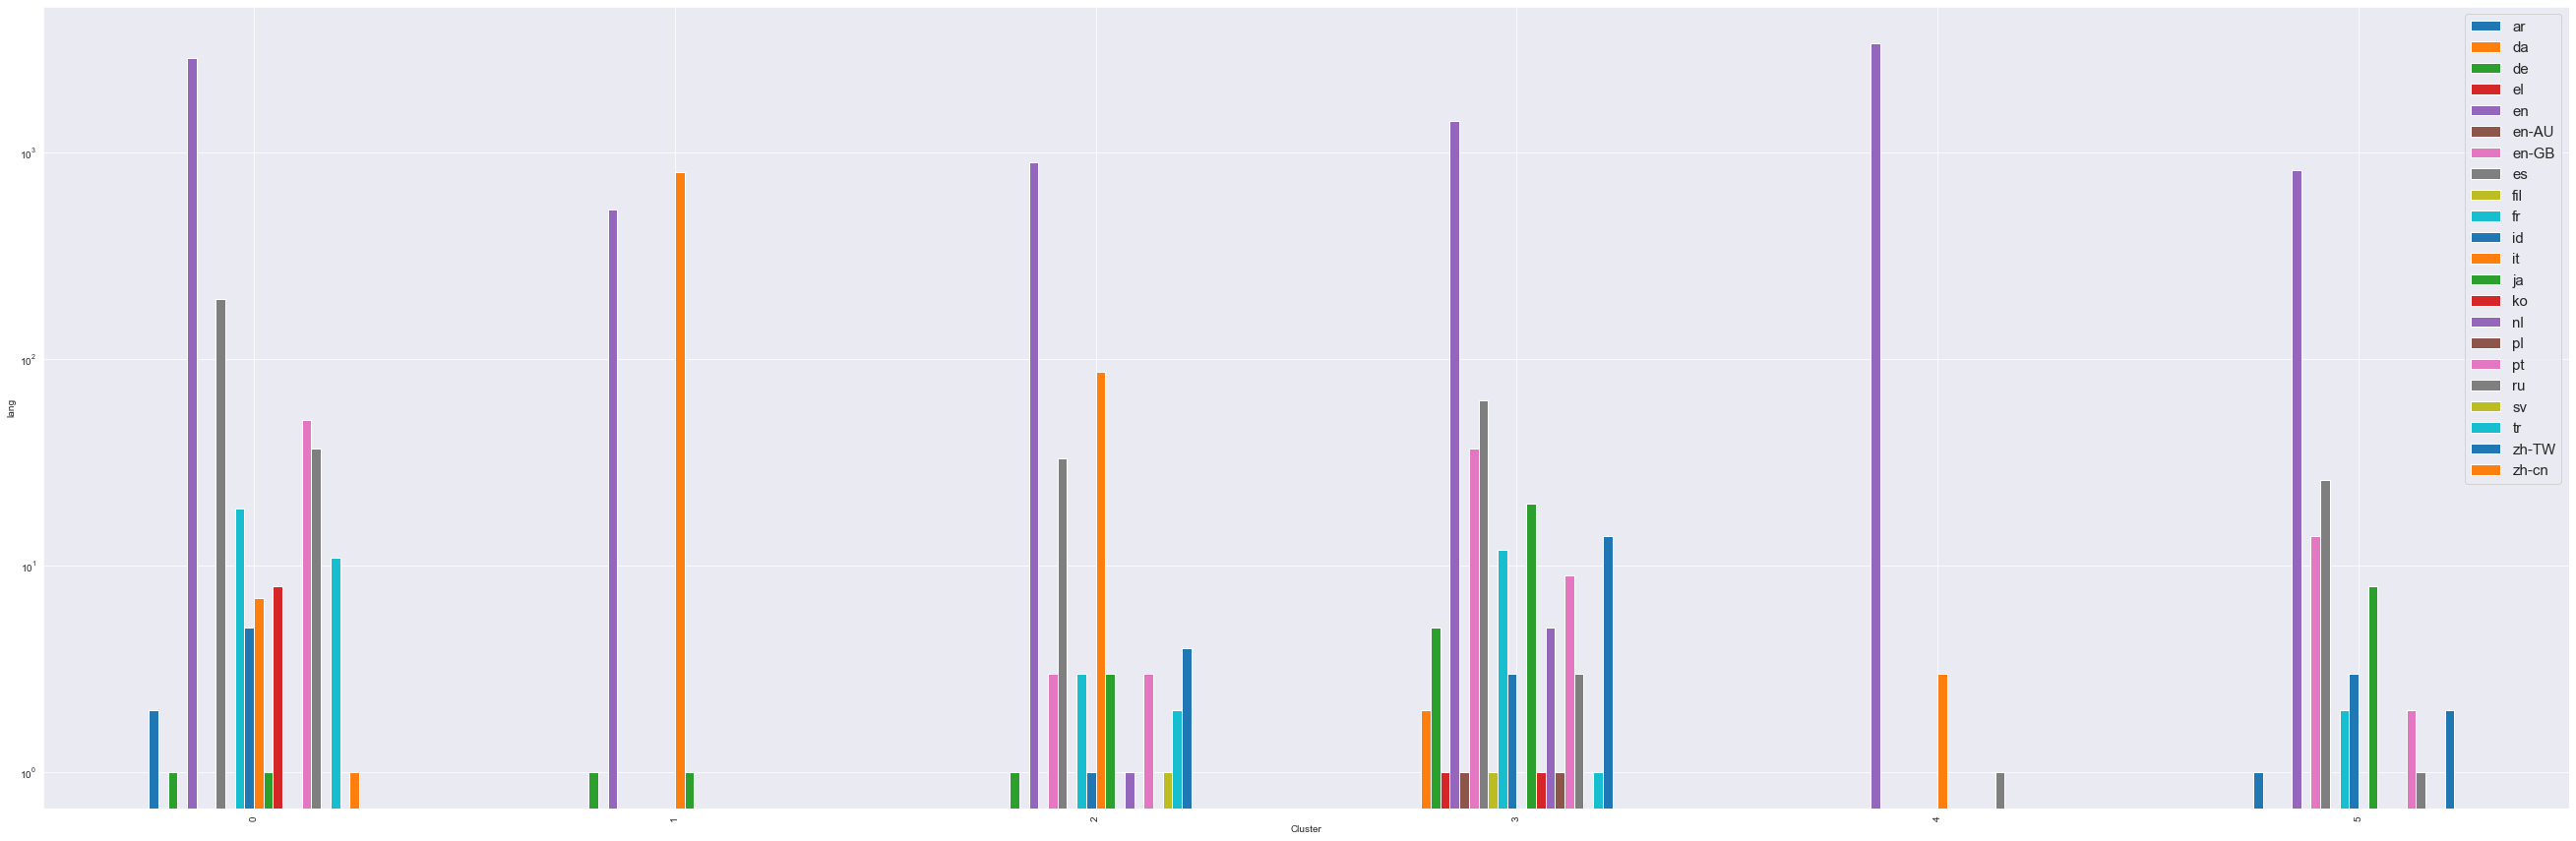

In [141]:
lang_ct = pd.crosstab(clusters.labels_, df_merge['lang'])

fig, ax = plt.subplots(figsize=(46, 15))
#plt.figure(figsize=(10,25))
lang_ct.plot(kind='bar', stacked=False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('lang')
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

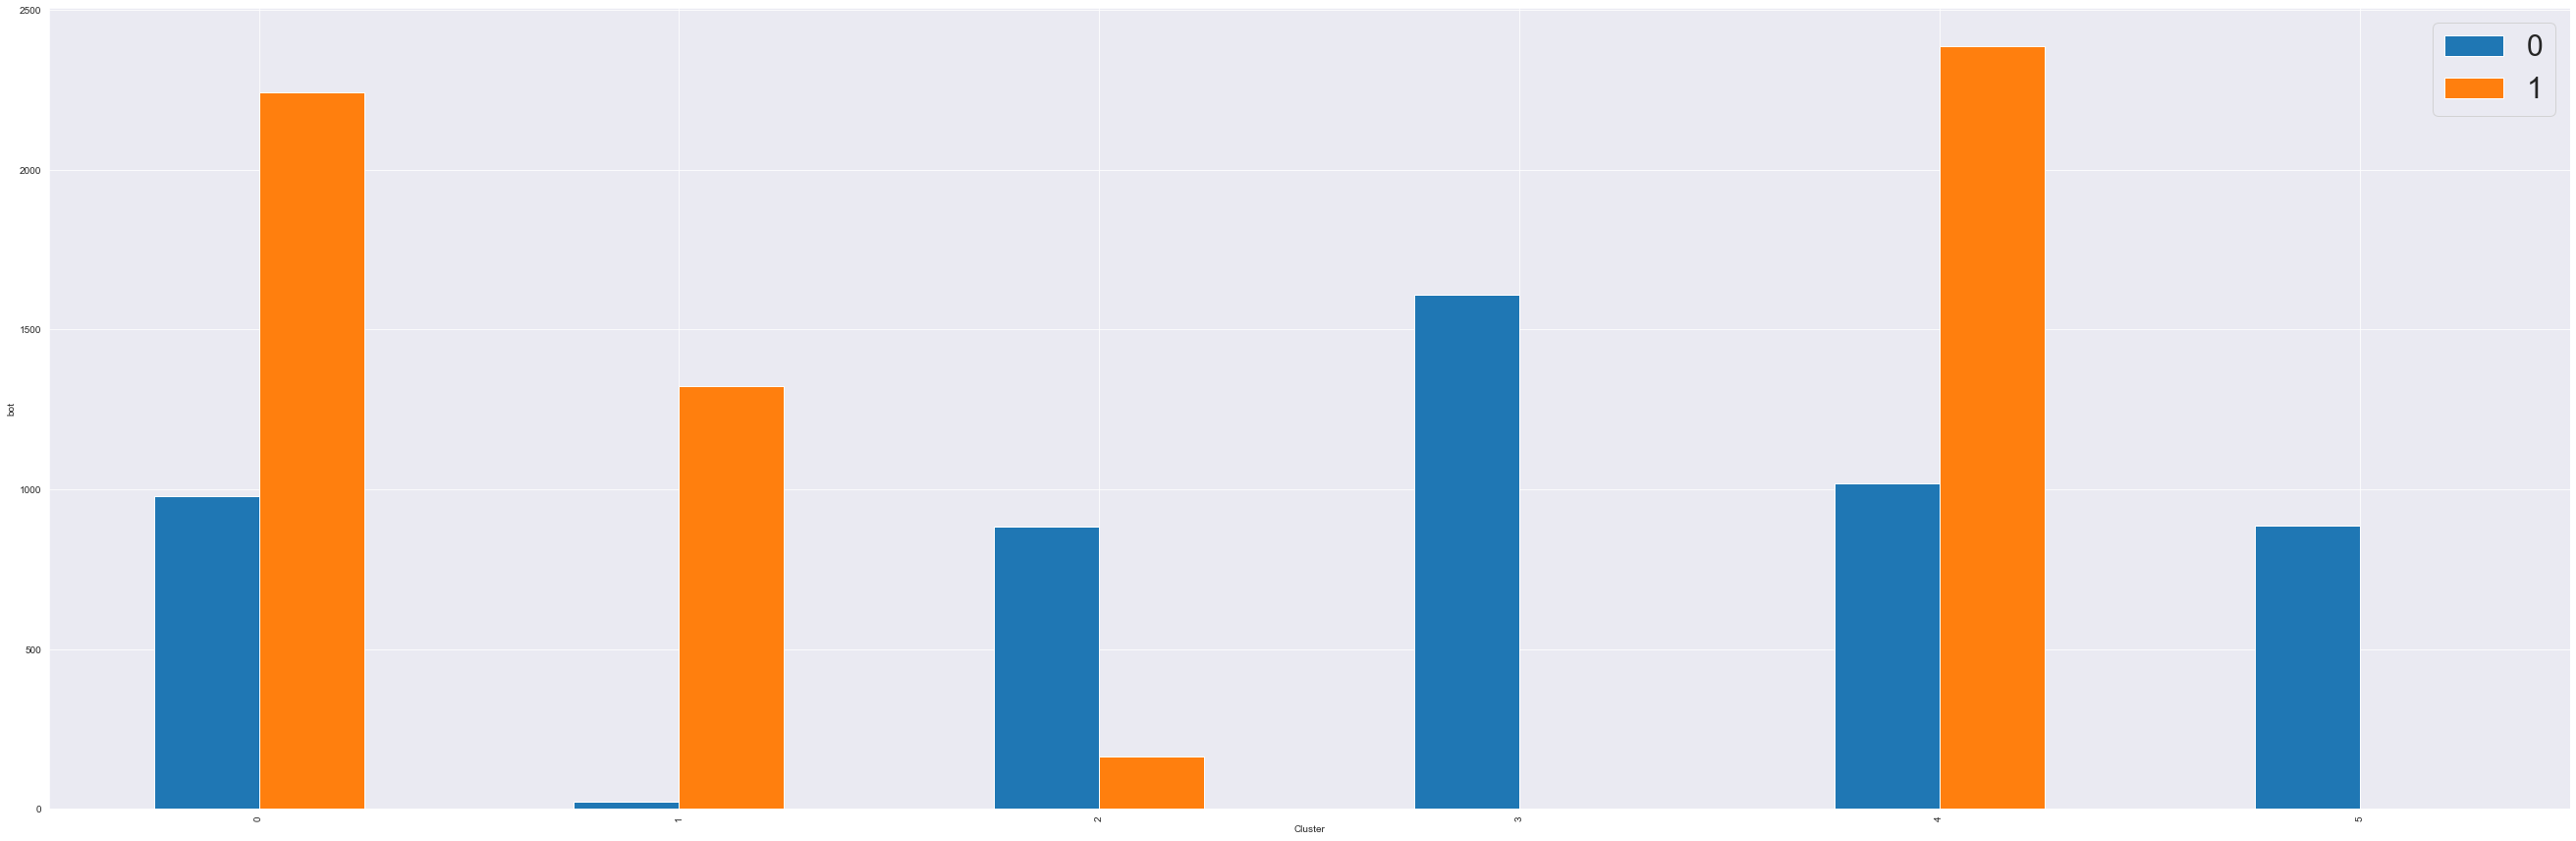

In [142]:
bot_ct = pd.crosstab(clusters.labels_, df_merge['bot'])

fig, ax = plt.subplots(figsize=(46, 15))  # Sample figsize in inches
#plt.figure(figsize=(10,25))
bot_ct.plot(kind='bar', stacked=False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('bot')
plt.legend(prop={'size': 30})
plt.show()